# DATA VISUALIZATION, EXPLORATION, AND MACHINE LEARNING APPLIED TO PROJECT-LEVEL DATA: HAINAN PROJECT

In [1]:
# Initialize packages
library(DataCombine)
library(reshape2)
library(car)
library(MASS)
library(ggplot2)
library(plotly)
library(GGally)
library(tidyverse)
library(RcppRoll)
library(psych)
library(rpart)
library(rpart.plot)
library(randomForest)
library(caret)
library(purrr)
library(broom)
library(ranger)
library(xgboost)
library(elasticnet)
library(penalized)
library(bst)
library(leaps)
library(e1071)
library(superpc)
library(kernlab)
library(pls)
library(keras)
library(tensorflow)
library(mboost)
library(import)
library(gridExtra)
library(glmnet)


Attaching package: 'plotly'

The following object is masked from 'package:ggplot2':

    last_plot

The following object is masked from 'package:MASS':

    select

The following object is masked from 'package:stats':

    filter

The following object is masked from 'package:graphics':

    layout

-- Attaching packages --------------------------------------- tidyverse 1.2.1 --
v tibble  1.4.1     v purrr   0.2.4
v tidyr   0.7.2     v dplyr   0.7.4
v readr   1.1.1     v stringr 1.2.0
v tibble  1.4.1     v forcats 0.2.0
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks plotly::filter(), stats::filter()
x dplyr::lag()    masks stats::lag()
x dplyr::recode() masks car::recode()
x dplyr::select() masks plotly::select(), MASS::select()
x purrr::some()   masks car::some()

Attaching package: 'psych'

The following objects are masked from 'package:ggplot2':

    %+%, alpha

The following object is masked from 'package:car':

    logit

r

In [32]:
#Global options (plot size, default = 7)
options(repr.plot.width=7, repr.plot.height=7)
theme_set(theme_minimal())

In [3]:
# Read in data file
filename <- 'hainan3.csv'
df <- read.csv(filename, na.strings=c("NA",""))

In [4]:
# Convert variables to numeric
df$Water_Aux <- as.numeric(df$Water_Aux)
df$ProjectElectricityUse_Aux <- as.numeric(df$ProjectElectricityUse_Aux)
df$FeCl_Aux <- as.numeric(df$FeCl_Aux)

In [5]:
# summary(df)

In [6]:
my_theme <- function(base_size = 10, base_family = "sans"){
  theme_minimal(base_size = base_size, base_family = base_family) +
    theme(
      axis.text = element_text(size = 10),
      axis.text.x = element_text(angle = 0, vjust = 0.5, hjust = 0.5),
      axis.title = element_text(size = 12),
      panel.grid.major = element_line(color = "grey"),
      panel.grid.minor = element_blank(),
      panel.background = element_rect(fill = "#fcf9ff"),
      strip.background = element_rect(fill = "#3d0066", color = "#3d0066", size =0.5),
      strip.text = element_text(face = "bold", size = 10, color = "white"),
      legend.position = "bottom",
      legend.justification = "center",
      legend.background = element_blank(),
      panel.border = element_rect(color = "grey30", fill = NA, size = 0.5)
    )
}
theme_set(my_theme())

myfill=c("#f32440","#249ff2","#ba33e8","#ffbd0a")

mycolor=c("#b20018","#012670","#2b0354","#c42f01")

# Feature Engineering
### In this section, we create new features derived from the original dataset. We start with new features derived from project inputs and outputs

In [7]:
# First we define a function that makes a histogram and prints the range for our derived
# variables, so that we can check that there aren't any problems

In [8]:
# Add a co-digested amount variable. This tells us how many co-digested substrates there were on 
# a given day
df$codigestedAmount <- as.integer(rowSums(df[ , grepl( "Input" , names( df ) ) ] > 0))

In [9]:
# Add a total waste input variable
df <- mutate(df, total_Input = select(df, contains("Input")) %>% rowSums(.))

In [10]:
# str(df)

In [11]:
#Add cumulative variables (inputs) running sums
df <- mutate(df,
             cum_total_Input = cumsum(df$total_Input),
             cum_PigManure_Input = cumsum(df$PigManure_Input),
             cum_Cassava_Input = cumsum(df$Cassava_Input),
             cum_FishWaste_Input = cumsum(df$FishWaste_Input),
             cum_FoodWaste_Input = cumsum(df$FoodWaste_Input),
             cum_MunFecalRes_Input = cumsum(df$MunFecalRes_Input),
             cum_TeaWaste_Input = cumsum(df$TeaWaste_Input),
             cum_ChickLitter_Input = cumsum(df$ChickLitter_Input),
             cum_Baggasse_Input = cumsum(df$Baggasse_Input),
             cum_AlcoWaste_Input = cumsum(df$AlcoWaste_Input),
             cum_MedicineWaste_Input = cumsum(df$MedicineWaste_Input),
             cum_EnergyGrass_Input = cumsum(df$EnergyGrass_Input),
             cum_BananaShafts_Input = cumsum(df$BananaShafts_Input),
             cum_LemonWaste_Input = cumsum(df$LemonWaste_Input),
             cum_Percolate_Input = cumsum(df$Percolate_Input),
             cum_Other_Input = cumsum(df$Other_Input))             

In [12]:
#Add cumulative variables (outputs) running sums
df <- mutate(df,
            cum_BioCNG_Output = cumsum(df$BioCNG_Output),
            cum_LiqFert_Output = cumsum(df$LiqFert_Output),
            cum_SolFert_Output = cumsum(df$SolFert_Output))

### Introduce a time lead variable

In [13]:
#One-day output in the future
df$BioCNG40daysAhead <- lead(df$BioCNG_Output, +40)
df$BioCNG30daysAhead <- lead(df$BioCNG_Output, +30)
df$BioCNG20daysAhead <- lead(df$BioCNG_Output, +20)
df$BioCNG10daysAhead <- lead(df$BioCNG_Output, +10)
df$BioCNG5daysAhead <- lead(df$BioCNG_Output, +5)
df$BioCNG3daysAhead <- lead(df$BioCNG_Output, +3)
df$BioCNG1daysAhead <- lead(df$BioCNG_Output, +1)

In [14]:
# summary(df)
# str(df)

# Machine learning
### In this section, we apply ML algorithms including, glmnet, decision trees, random forest, and xgboost to predict future output.

In [15]:
#Get ride of na values
df2 <- subset(df, BioCNG40daysAhead != "NA")
# sum(is.na(df2) == TRUE)
# sum(is.na(df2))

In [16]:
#Determine the train-test split ratio
trainRatio = 0.90
split <- round(nrow(df2)*trainRatio)
train <- df2[1:split,]
test <- df2[(split + 1):nrow(df2), ]

In [17]:
#Define OSR2 function
# convenience function, you're welcome :) 
OSR2 <- function(predictions, test, train) {
  SSE <- sum((test - predictions)^2)
  SST <- sum((test - mean(train))^2)
  r2 <- 1 - SSE/SST
  return(r2)
}

In [18]:
#Set seed for reproducible results
set.seed(1)

### Testing optimal timeframe: 40 days

#### Linear model

In [19]:
# Train a linear model
mod_lm40 <- train(BioCNG40daysAhead ~ 
           cum_BioCNG_Output +
           BioCNG_Output +
           PigManure_Input + Cassava_Input + FishWaste_Input + FoodWaste_Input +
           MunFecalRes_Input + TeaWaste_Input + ChickLitter_Input + Baggasse_Input +
           AlcoWaste_Input + MedicineWaste_Input + EnergyGrass_Input + BananaShafts_Input +
           LemonWaste_Input + Percolate_Input + Other_Input + codigestedAmount + total_Input +
           cum_total_Input + cum_PigManure_Input + cum_Cassava_Input + cum_FishWaste_Input +
           cum_FoodWaste_Input + cum_MunFecalRes_Input + cum_TeaWaste_Input + 
           cum_ChickLitter_Input + cum_Baggasse_Input + cum_AlcoWaste_Input +
           cum_MedicineWaste_Input + cum_EnergyGrass_Input + cum_BananaShafts_Input +
           cum_LemonWaste_Input + cum_Percolate_Input + cum_Other_Input,
           method = "lm", metric = "RMSE",
           data = train)

Warning message in predict.lm(modelFit, newdata):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(modelFit, newdata):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(modelFit, newdata):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(modelFit, newdata):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(modelFit, newdata):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(modelFit, newdata):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(modelFit, newdata):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(modelFit, newdata):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(modelFit, newdata):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(modelFit, newdat

In [20]:
# Check model performance
mod_lm40

Linear Regression 

1222 samples
  35 predictor

No pre-processing
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 1222, 1222, 1222, 1222, 1222, 1222, ... 
Resampling results:

  RMSE      Rsquared   MAE     
  1871.761  0.7061859  1353.346

Tuning parameter 'intercept' was held constant at a value of TRUE

In [21]:
# Create a new vector in the dataframe with model's predicted values 
test$lm40_preds <- predict(mod_lm40, test)

Warning message in predict.lm(modelFit, newdata):
"prediction from a rank-deficient fit may be misleading"

In [22]:
# Calculate out-of-sample R2
lm40_OSR2 <- OSR2(test$lm40_preds, test$BioCNG40daysAhead, train$BioCNG40daysAhead)
lm40_OSR2

[1] -0.3614132

#### Elastic net

In [26]:
#Train model
mod_enet_tuned40 <-train(BioCNG40daysAhead ~ 
           cum_BioCNG_Output +
           BioCNG_Output +
           PigManure_Input + Cassava_Input + FishWaste_Input + FoodWaste_Input +
           MunFecalRes_Input + TeaWaste_Input + ChickLitter_Input + Baggasse_Input +
           AlcoWaste_Input + MedicineWaste_Input + EnergyGrass_Input + BananaShafts_Input +
           LemonWaste_Input + Percolate_Input + Other_Input + codigestedAmount + total_Input +
           cum_total_Input + cum_PigManure_Input + cum_Cassava_Input + cum_FishWaste_Input +
           cum_FoodWaste_Input + cum_MunFecalRes_Input + cum_TeaWaste_Input + 
           cum_ChickLitter_Input + cum_Baggasse_Input + cum_AlcoWaste_Input +
           cum_MedicineWaste_Input + cum_EnergyGrass_Input + cum_BananaShafts_Input +
           cum_LemonWaste_Input + cum_Percolate_Input + cum_Other_Input,
                     data=train,
                     method="glmnet",
                     metric="RMSE",
                     tuneLength = 5)

In [27]:
# Check model performance
mod_enet_tuned40

glmnet 

1222 samples
  35 predictor

No pre-processing
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 1222, 1222, 1222, 1222, 1222, 1222, ... 
Resampling results across tuning parameters:

  alpha  lambda       RMSE      Rsquared   MAE     
  0.100     2.429435  1941.508  0.6871690  1389.050
  0.100    11.276439  2003.261  0.6671369  1447.301
  0.100    52.340592  2094.425  0.6363262  1544.111
  0.100   242.943507  2149.561  0.6170733  1610.994
  0.100  1127.643870  2194.934  0.6048531  1686.513
  0.325     2.429435  1934.637  0.6894171  1383.348
  0.325    11.276439  2003.361  0.6671576  1448.956
  0.325    52.340592  2107.703  0.6317425  1562.524
  0.325   242.943507  2160.861  0.6140981  1639.224
  0.325  1127.643870  2271.899  0.5911734  1775.838
  0.550     2.429435  1930.078  0.6908880  1379.332
  0.550    11.276439  2003.325  0.6672439  1450.469
  0.550    52.340592  2121.000  0.6271127  1580.061
  0.550   242.943507  2172.805  0.6112118  1659.922
  0.550  1127.64

Warning message:
"Ignoring unknown aesthetics: shape"

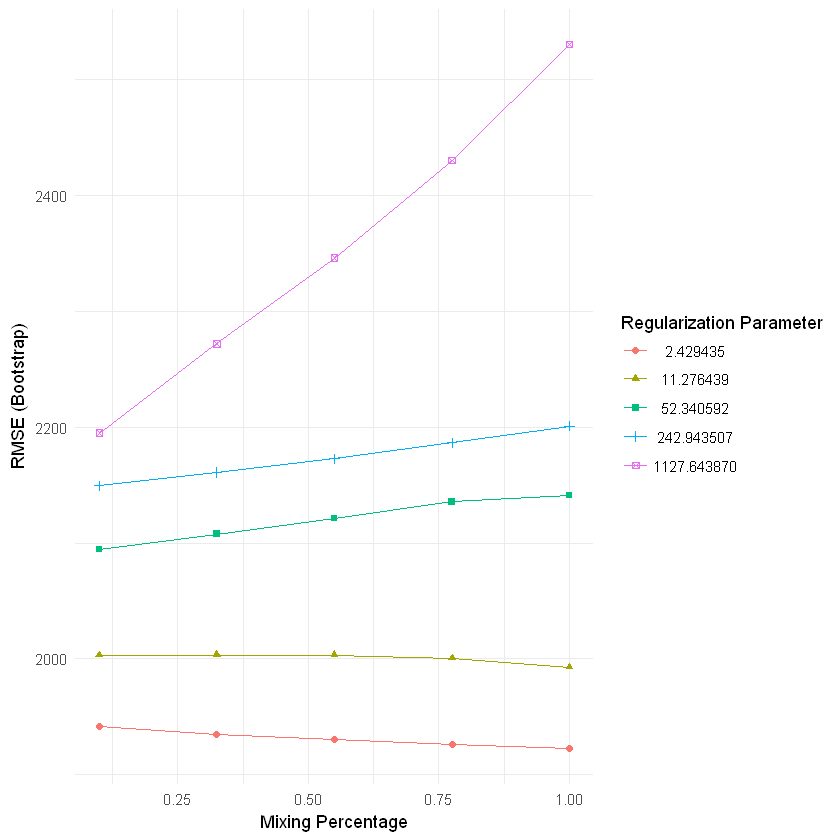

In [33]:
ggplot(mod_enet_tuned40)

In [34]:
# Create a new vector in the dataframe with model's predicted values 
test$enet40_preds <- predict(mod_enet_tuned40, test)

In [35]:
# Calculate out-of-sample R2
enet40_OSR2 <- OSR2(test$enet40_preds, test$BioCNG40daysAhead, train$BioCNG40daysAhead)
enet40_OSR2

[1] 0.3504997

#### Random forest

In [254]:
# Training model to predict output 40 days ahead
mod_rf_tuned40 <- train(BioCNG40daysAhead ~ 
           cum_BioCNG_Output +
           BioCNG_Output +
           PigManure_Input + Cassava_Input + FishWaste_Input + FoodWaste_Input +
           MunFecalRes_Input + TeaWaste_Input + ChickLitter_Input + Baggasse_Input +
           AlcoWaste_Input + MedicineWaste_Input + EnergyGrass_Input + BananaShafts_Input +
           LemonWaste_Input + Percolate_Input + Other_Input + codigestedAmount + total_Input +
           cum_total_Input + cum_PigManure_Input + cum_Cassava_Input + cum_FishWaste_Input +
           cum_FoodWaste_Input + cum_MunFecalRes_Input + cum_TeaWaste_Input + 
           cum_ChickLitter_Input + cum_Baggasse_Input + cum_AlcoWaste_Input +
           cum_MedicineWaste_Input + cum_EnergyGrass_Input + cum_BananaShafts_Input +
           cum_LemonWaste_Input + cum_Percolate_Input + cum_Other_Input,
           method = "ranger", metric = "RMSE", tuneLength = 5, importance = "impurity",
           data = train)

In [255]:
# Check model performance
mod_rf_tuned40

Random Forest 

1222 samples
  35 predictor

No pre-processing
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 1222, 1222, 1222, 1222, 1222, 1222, ... 
Resampling results across tuning parameters:

  mtry  splitrule   RMSE      Rsquared   MAE      
   2    variance    1629.418  0.7814981  1136.1212
   2    extratrees  1782.974  0.7397473  1276.2233
  10    variance    1382.989  0.8404264   880.3133
  10    extratrees  1396.366  0.8374998   894.8288
  18    variance    1445.777  0.8254661   927.3217
  18    extratrees  1398.656  0.8368781   893.8866
  26    variance    1494.698  0.8134260   966.3211
  26    extratrees  1405.463  0.8353074   898.7876
  35    variance    1538.283  0.8022821   999.5870
  35    extratrees  1412.673  0.8335795   906.1866

Tuning parameter 'min.node.size' was held constant at a value of 5
RMSE was used to select the optimal model using the smallest value.
The final values used for the model were mtry = 10, splitrule = variance
 and min.node.size 

Warning message:
"Ignoring unknown aesthetics: shape"

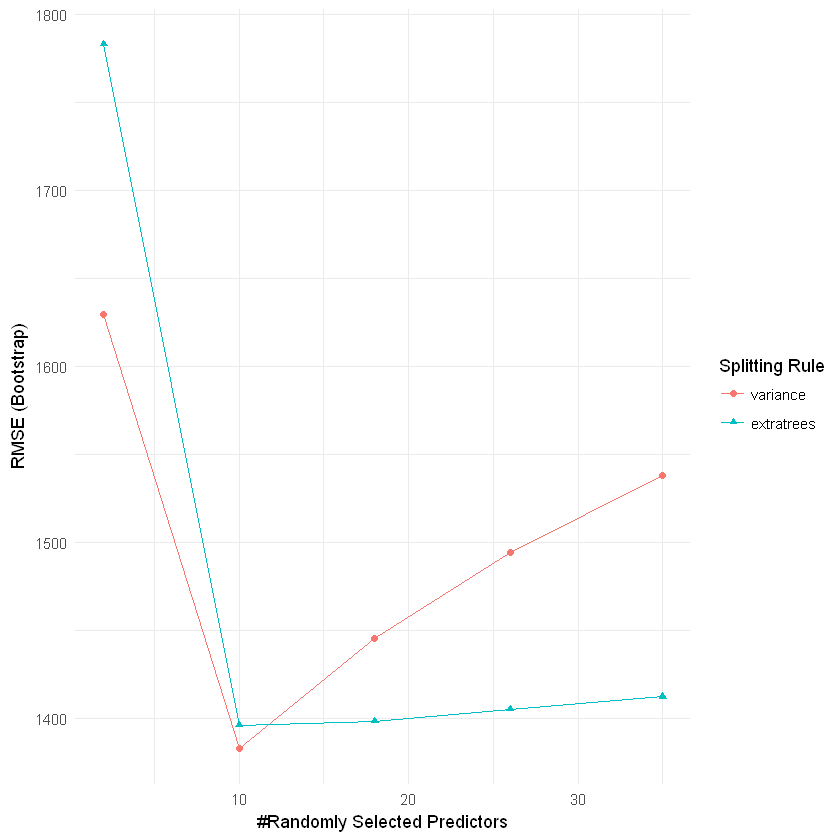

In [256]:
ggplot(mod_rf_tuned40)

In [257]:
# Create a new vector in the dataframe with model's predicted values 
test$rf_tuned40_preds <- predict(mod_rf_tuned40, test)

In [258]:
# Calculate out-of-sample R2
mod_rf_tuned40_OSR2 <- OSR2(test$rf_tuned40_preds, test$BioCNG40daysAhead, train$BioCNG40daysAhead)
mod_rf_tuned40_OSR2

[1] 0.8164642

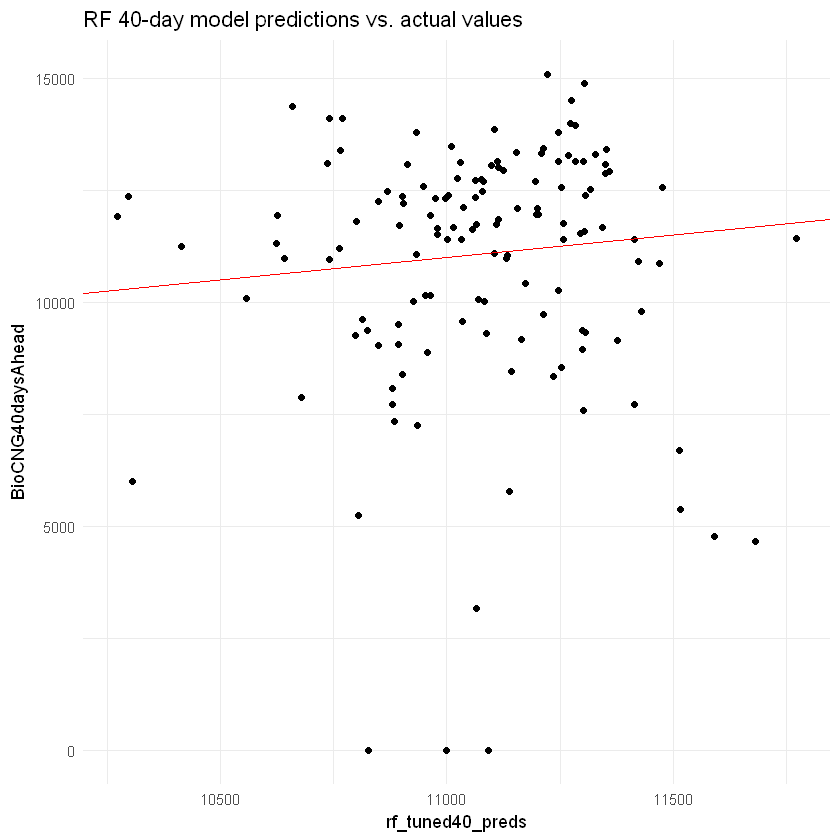

In [259]:
# Scatterplot of predicted vs. acual values
ggplot(test, aes(x=rf_tuned40_preds, y=BioCNG40daysAhead)) + 
  geom_point() +
  geom_abline(color = 'red') +
  ggtitle("RF 40-day model predictions vs. actual values")

In [260]:
# New vector of residuals
test$rf_tuned40_residuals <- test$BioCNG40daysAhead - test$rf_tuned40_preds

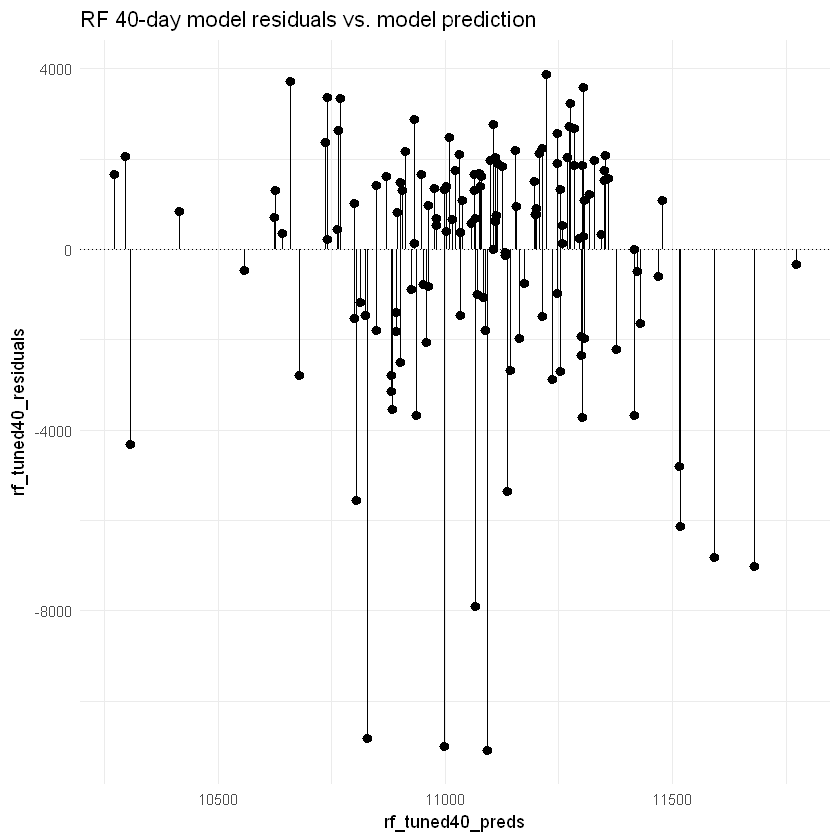

In [261]:
# plot of residuals 
ggplot(test, aes(x = rf_tuned40_preds, y = rf_tuned40_residuals)) + 
  geom_pointrange(aes(ymin = 0, ymax = rf_tuned40_residuals)) + 
  geom_hline(yintercept = 0, linetype = 3) + 
  ggtitle("RF 40-day model residuals vs. model prediction")

In [262]:
# mod_rf_tuned40$results

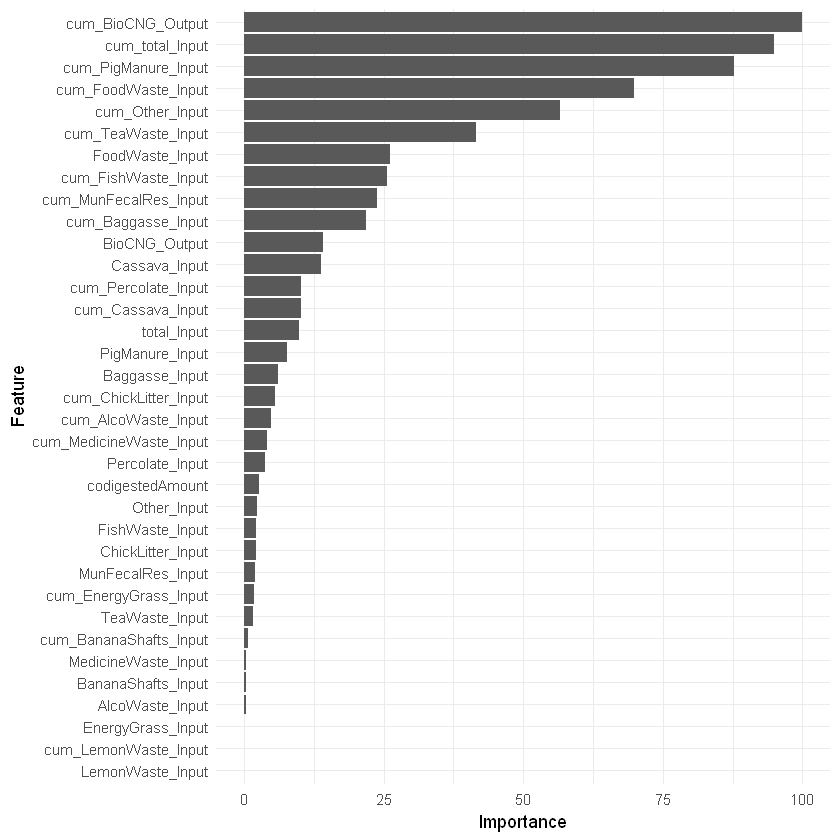

In [263]:
# Variable importance plot
ggplot(varImp(mod_rf_tuned40))

#### XGBoost

In [248]:
#Train model
mod_xgb_tuned40 <-train(BioCNG40daysAhead ~ 
           cum_BioCNG_Output +
           BioCNG_Output +
           PigManure_Input + Cassava_Input + FishWaste_Input + FoodWaste_Input +
           MunFecalRes_Input + TeaWaste_Input + ChickLitter_Input + Baggasse_Input +
           AlcoWaste_Input + MedicineWaste_Input + EnergyGrass_Input + BananaShafts_Input +
           LemonWaste_Input + Percolate_Input + Other_Input + codigestedAmount + total_Input +
           cum_total_Input + cum_PigManure_Input + cum_Cassava_Input + cum_FishWaste_Input +
           cum_FoodWaste_Input + cum_MunFecalRes_Input + cum_TeaWaste_Input + 
           cum_ChickLitter_Input + cum_Baggasse_Input + cum_AlcoWaste_Input +
           cum_MedicineWaste_Input + cum_EnergyGrass_Input + cum_BananaShafts_Input +
           cum_LemonWaste_Input + cum_Percolate_Input + cum_Other_Input,
                     data=train,
                     method="xgbTree",
                     verbose=F,
                     metric="RMSE", importance = "impurity",
                     tuneLength = 3)

In [249]:
# Check model performance
mod_xgb_tuned40

eXtreme Gradient Boosting 

1222 samples
  35 predictor

No pre-processing
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 1222, 1222, 1222, 1222, 1222, 1222, ... 
Resampling results across tuning parameters:

  eta  max_depth  colsample_bytree  subsample  nrounds  RMSE      Rsquared 
  0.3  1          0.6               0.50        50      1890.916  0.7073958
  0.3  1          0.6               0.50       100      1827.055  0.7270999
  0.3  1          0.6               0.50       150      1791.435  0.7374581
  0.3  1          0.6               0.75        50      1871.184  0.7136793
  0.3  1          0.6               0.75       100      1804.361  0.7337971
  0.3  1          0.6               0.75       150      1764.830  0.7452323
  0.3  1          0.6               1.00        50      1869.916  0.7148527
  0.3  1          0.6               1.00       100      1796.493  0.7368480
  0.3  1          0.6               1.00       150      1757.216  0.7479856
  0.3  1         

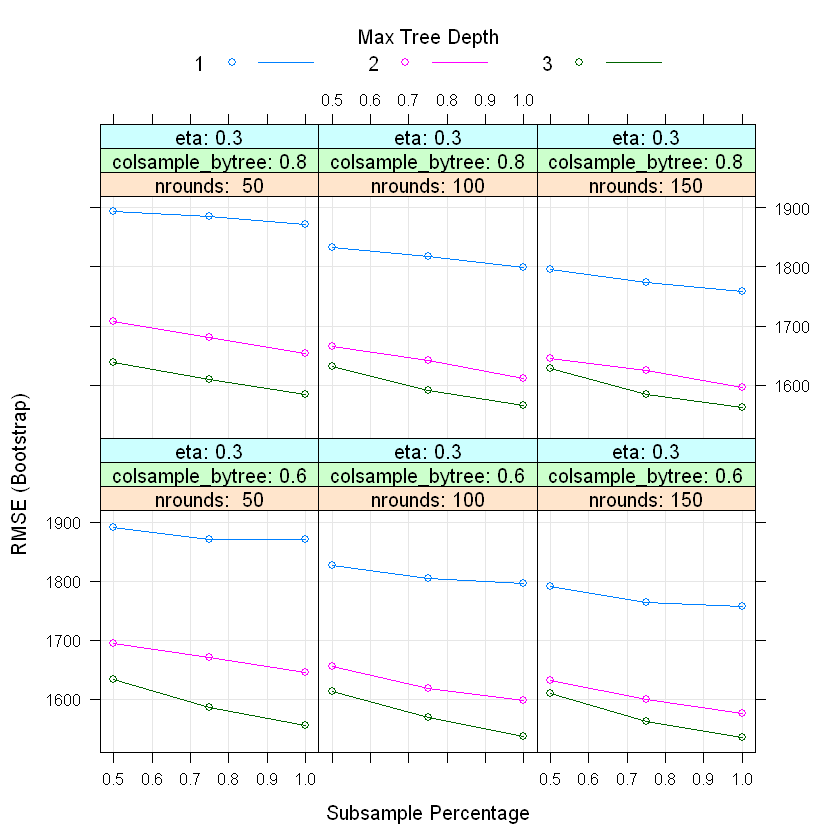

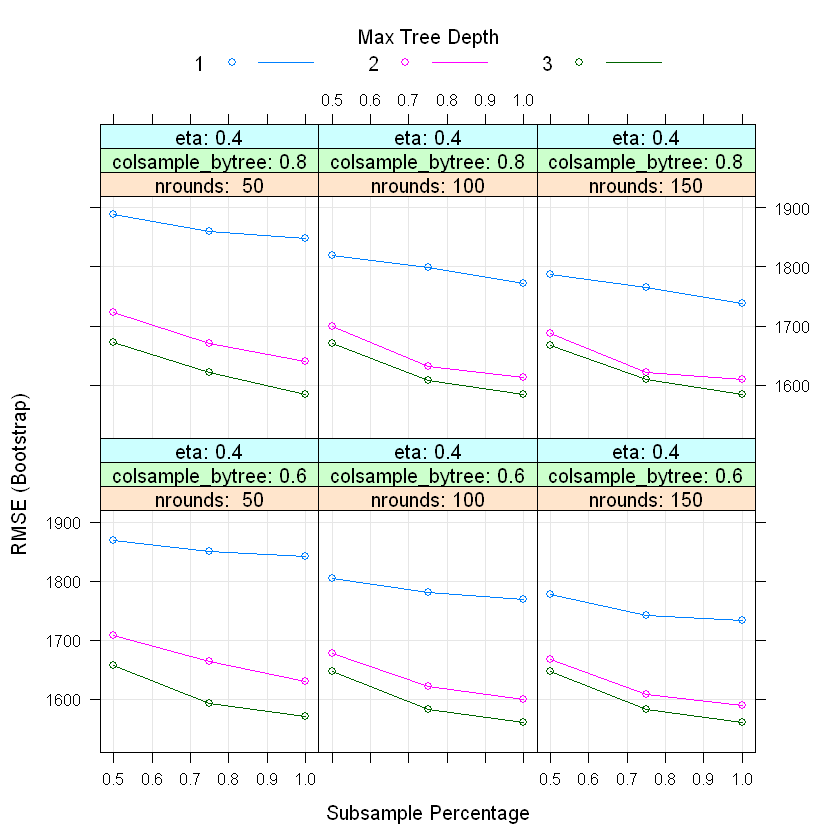

In [250]:
plot(mod_xgb_tuned40)

In [251]:
# Create a new vector in the dataframe with model's predicted values 
test$xgb_tuned40_preds <- predict(mod_xgb_tuned40, test)

In [252]:
# Calculate out-of-sample R2
mod_xgb_tuned40_OSR2 <- OSR2(test$xgb_tuned40_preds, test$BioCNG40daysAhead, train$BioCNG40daysAhead)
mod_xgb_tuned40_OSR2

[1] 0.812084

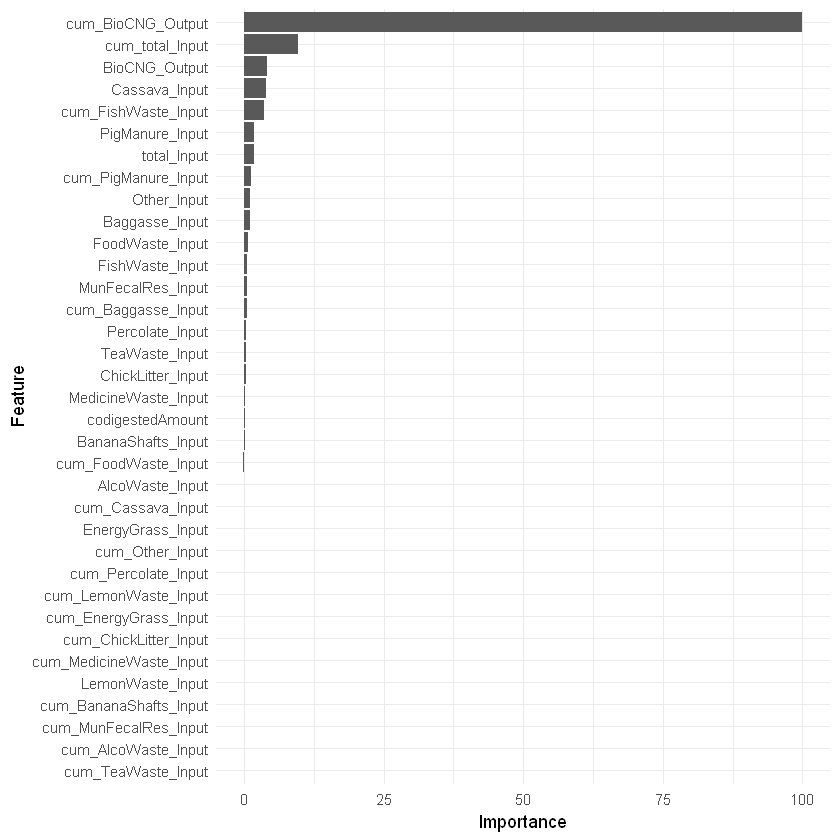

In [253]:
# Variable importance plot
ggplot(varImp(mod_xgb_tuned40))

### Testing optimal time frame: 30 days

#### Linear model

In [54]:
# Train model
mod_lm30 <- train(BioCNG30daysAhead ~ 
           cum_BioCNG_Output +
           BioCNG_Output +
           PigManure_Input + Cassava_Input + FishWaste_Input + FoodWaste_Input +
           MunFecalRes_Input + TeaWaste_Input + ChickLitter_Input + Baggasse_Input +
           AlcoWaste_Input + MedicineWaste_Input + EnergyGrass_Input + BananaShafts_Input +
           LemonWaste_Input + Percolate_Input + Other_Input + codigestedAmount + total_Input +
           cum_total_Input + cum_PigManure_Input + cum_Cassava_Input + cum_FishWaste_Input +
           cum_FoodWaste_Input + cum_MunFecalRes_Input + cum_TeaWaste_Input + 
           cum_ChickLitter_Input + cum_Baggasse_Input + cum_AlcoWaste_Input +
           cum_MedicineWaste_Input + cum_EnergyGrass_Input + cum_BananaShafts_Input +
           cum_LemonWaste_Input + cum_Percolate_Input + cum_Other_Input,
           method = "lm", metric = "RMSE",
           data = train)

Warning message in predict.lm(modelFit, newdata):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(modelFit, newdata):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(modelFit, newdata):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(modelFit, newdata):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(modelFit, newdata):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(modelFit, newdata):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(modelFit, newdata):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(modelFit, newdata):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(modelFit, newdata):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(modelFit, newdat

In [55]:
# Check model performance
mod_lm30

Linear Regression 

1222 samples
  35 predictor

No pre-processing
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 1222, 1222, 1222, 1222, 1222, 1222, ... 
Resampling results:

  RMSE      Rsquared   MAE     
  1882.394  0.7009647  1329.936

Tuning parameter 'intercept' was held constant at a value of TRUE

In [56]:
# Create a new vector in the dataframe with model's predicted values 
test$lm30_preds <- predict(mod_lm30, test)

Warning message in predict.lm(modelFit, newdata):
"prediction from a rank-deficient fit may be misleading"

In [57]:
# Calculate out-of-sample R2
lm30_OSR2 <- OSR2(test$lm30_preds, test$BioCNG30daysAhead, train$BioCNG30daysAhead)
lm30_OSR2

[1] -1.594613

#### Elastic net

In [58]:
#Train model
mod_enet_tuned30 <-train(BioCNG30daysAhead ~ 
           cum_BioCNG_Output +
           BioCNG_Output +
           PigManure_Input + Cassava_Input + FishWaste_Input + FoodWaste_Input +
           MunFecalRes_Input + TeaWaste_Input + ChickLitter_Input + Baggasse_Input +
           AlcoWaste_Input + MedicineWaste_Input + EnergyGrass_Input + BananaShafts_Input +
           LemonWaste_Input + Percolate_Input + Other_Input + codigestedAmount + total_Input +
           cum_total_Input + cum_PigManure_Input + cum_Cassava_Input + cum_FishWaste_Input +
           cum_FoodWaste_Input + cum_MunFecalRes_Input + cum_TeaWaste_Input + 
           cum_ChickLitter_Input + cum_Baggasse_Input + cum_AlcoWaste_Input +
           cum_MedicineWaste_Input + cum_EnergyGrass_Input + cum_BananaShafts_Input +
           cum_LemonWaste_Input + cum_Percolate_Input + cum_Other_Input,
                     data=train,
                     method="glmnet",
                     metric="RMSE",
                     tuneLength = 5)

In [59]:
# Check model performance
mod_enet_tuned30

glmnet 

1222 samples
  35 predictor

No pre-processing
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 1222, 1222, 1222, 1222, 1222, 1222, ... 
Resampling results across tuning parameters:

  alpha  lambda      RMSE      Rsquared   MAE     
  0.100     2.39684  1915.387  0.6970929  1349.017
  0.100    11.12514  1994.658  0.6715765  1421.418
  0.100    51.63835  2097.362  0.6368886  1521.109
  0.100   239.68397  2159.246  0.6150515  1592.941
  0.100  1112.51443  2214.397  0.5977818  1675.345
  0.325     2.39684  1907.853  0.6994952  1341.404
  0.325    11.12514  1997.179  0.6707274  1422.298
  0.325    51.63835  2113.999  0.6309679  1538.754
  0.325   239.68397  2182.908  0.6069561  1628.568
  0.325  1112.51443  2275.613  0.5875376  1758.026
  0.550     2.39684  1902.503  0.7012042  1336.172
  0.550    11.12514  1999.589  0.6699140  1423.471
  0.550    51.63835  2129.308  0.6255562  1555.344
  0.550   239.68397  2199.314  0.6018877  1652.927
  0.550  1112.51443  2336.528  

Warning message:
"Ignoring unknown aesthetics: shape"

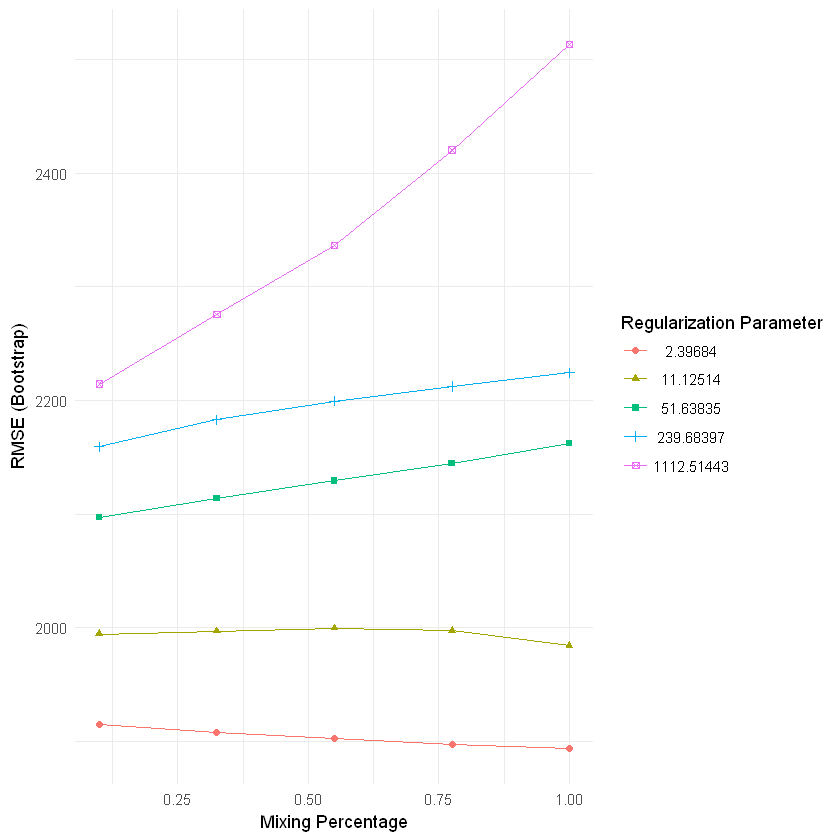

In [60]:
ggplot(mod_enet_tuned30)

In [61]:
# Create a new vector in the dataframe with model's predicted values 
test$enet30_preds <- predict(mod_enet_tuned30, test)

In [62]:
# Calculate out-of-sample R2
enet30_OSR2 <- OSR2(test$enet30_preds, test$BioCNG30daysAhead, train$BioCNG30daysAhead)
enet30_OSR2

[1] 0.666921

#### Random forest

In [63]:
# Training model to predict output 40 days ahead
mod_rf_tuned30 <- train(BioCNG30daysAhead ~ 
           cum_BioCNG_Output +
           BioCNG_Output +
           PigManure_Input + Cassava_Input + FishWaste_Input + FoodWaste_Input +
           MunFecalRes_Input + TeaWaste_Input + ChickLitter_Input + Baggasse_Input +
           AlcoWaste_Input + MedicineWaste_Input + EnergyGrass_Input + BananaShafts_Input +
           LemonWaste_Input + Percolate_Input + Other_Input + codigestedAmount + total_Input +
           cum_total_Input + cum_PigManure_Input + cum_Cassava_Input + cum_FishWaste_Input +
           cum_FoodWaste_Input + cum_MunFecalRes_Input + cum_TeaWaste_Input + 
           cum_ChickLitter_Input + cum_Baggasse_Input + cum_AlcoWaste_Input +
           cum_MedicineWaste_Input + cum_EnergyGrass_Input + cum_BananaShafts_Input +
           cum_LemonWaste_Input + cum_Percolate_Input + cum_Other_Input,
           method = "ranger", metric = "RMSE", tuneLength = 5,
           data = train)

In [64]:
# Check model performance
mod_rf_tuned30

Random Forest 

1222 samples
  35 predictor

No pre-processing
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 1222, 1222, 1222, 1222, 1222, 1222, ... 
Resampling results across tuning parameters:

  mtry  splitrule   RMSE      Rsquared   MAE      
   2    variance    1619.116  0.7822972  1116.6991
   2    extratrees  1786.732  0.7363922  1264.7261
  10    variance    1369.469  0.8413233   879.0236
  10    extratrees  1363.025  0.8429584   879.2922
  18    variance    1425.622  0.8281365   925.1634
  18    extratrees  1364.598  0.8425211   881.4503
  26    variance    1476.085  0.8158152   966.4039
  26    extratrees  1371.018  0.8409672   885.8726
  35    variance    1518.358  0.8052765   999.0599
  35    extratrees  1381.469  0.8385679   894.5973

Tuning parameter 'min.node.size' was held constant at a value of 5
RMSE was used to select the optimal model using the smallest value.
The final values used for the model were mtry = 10, splitrule = extratrees
 and min.node.siz

Warning message:
"Ignoring unknown aesthetics: shape"

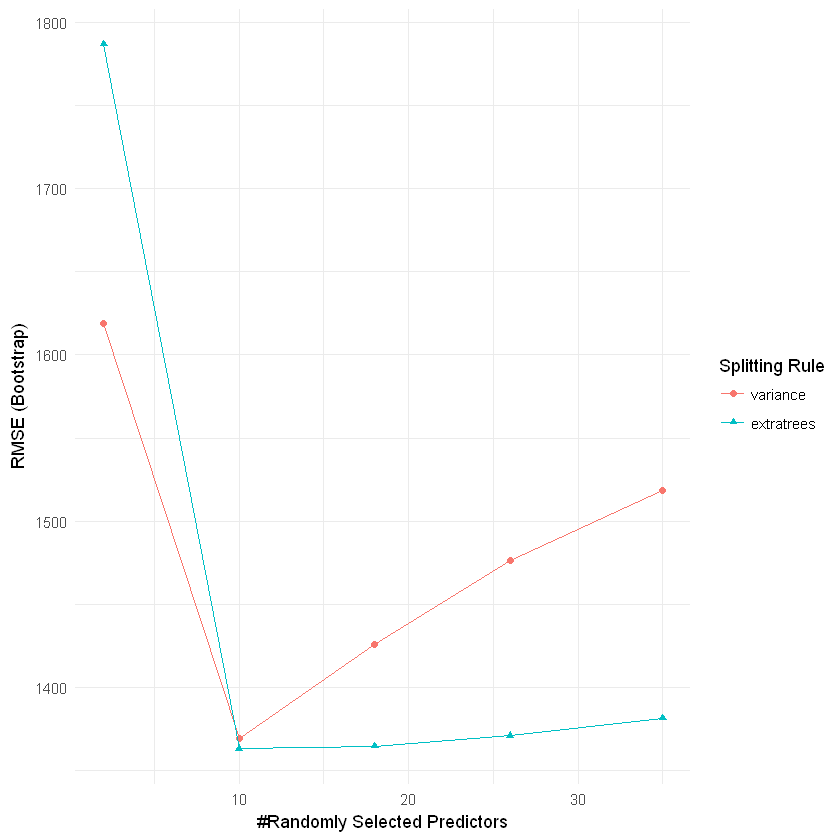

In [65]:
ggplot(mod_rf_tuned30)

In [66]:
# Create a new vector in the dataframe with model's predicted values 
test$rf_tuned30_preds <- predict(mod_rf_tuned30, test)

In [67]:
# Calculate out-of-sample R2
mod_rf_tuned30_OSR2 <- OSR2(test$rf_tuned30_preds, test$BioCNG30daysAhead, train$BioCNG30daysAhead)
mod_rf_tuned30_OSR2

[1] 0.838908

#### XGBoost

In [68]:
#Train model
mod_xgb_tuned30 <-train(BioCNG30daysAhead ~ 
           cum_BioCNG_Output +
           BioCNG_Output +
           PigManure_Input + Cassava_Input + FishWaste_Input + FoodWaste_Input +
           MunFecalRes_Input + TeaWaste_Input + ChickLitter_Input + Baggasse_Input +
           AlcoWaste_Input + MedicineWaste_Input + EnergyGrass_Input + BananaShafts_Input +
           LemonWaste_Input + Percolate_Input + Other_Input + codigestedAmount + total_Input +
           cum_total_Input + cum_PigManure_Input + cum_Cassava_Input + cum_FishWaste_Input +
           cum_FoodWaste_Input + cum_MunFecalRes_Input + cum_TeaWaste_Input + 
           cum_ChickLitter_Input + cum_Baggasse_Input + cum_AlcoWaste_Input +
           cum_MedicineWaste_Input + cum_EnergyGrass_Input + cum_BananaShafts_Input +
           cum_LemonWaste_Input + cum_Percolate_Input + cum_Other_Input,
                     data=train,
                     method="xgbTree",
                     verbose=F,
                     metric="RMSE",
                     tuneLength = 3)

In [69]:
# Check model performance
mod_xgb_tuned30

eXtreme Gradient Boosting 

1222 samples
  35 predictor

No pre-processing
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 1222, 1222, 1222, 1222, 1222, 1222, ... 
Resampling results across tuning parameters:

  eta  max_depth  colsample_bytree  subsample  nrounds  RMSE      Rsquared 
  0.3  1          0.6               0.50        50      1871.879  0.7007659
  0.3  1          0.6               0.50       100      1813.411  0.7186832
  0.3  1          0.6               0.50       150      1776.503  0.7295988
  0.3  1          0.6               0.75        50      1856.002  0.7060078
  0.3  1          0.6               0.75       100      1789.922  0.7263861
  0.3  1          0.6               0.75       150      1754.133  0.7368079
  0.3  1          0.6               1.00        50      1849.295  0.7091351
  0.3  1          0.6               1.00       100      1779.876  0.7299448
  0.3  1          0.6               1.00       150      1740.125  0.7414610
  0.3  1         

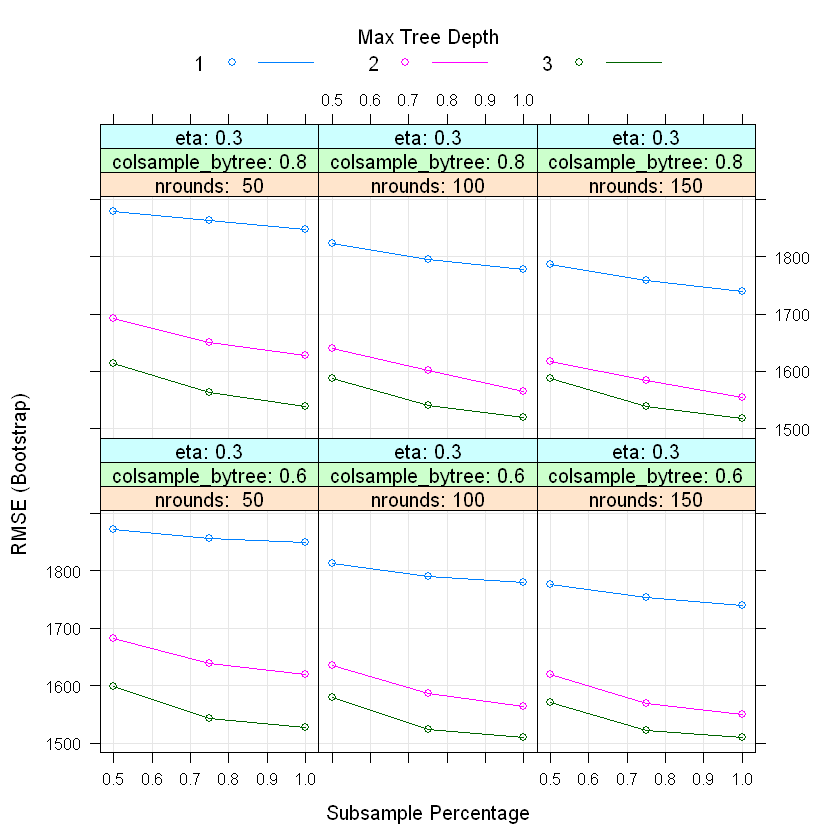

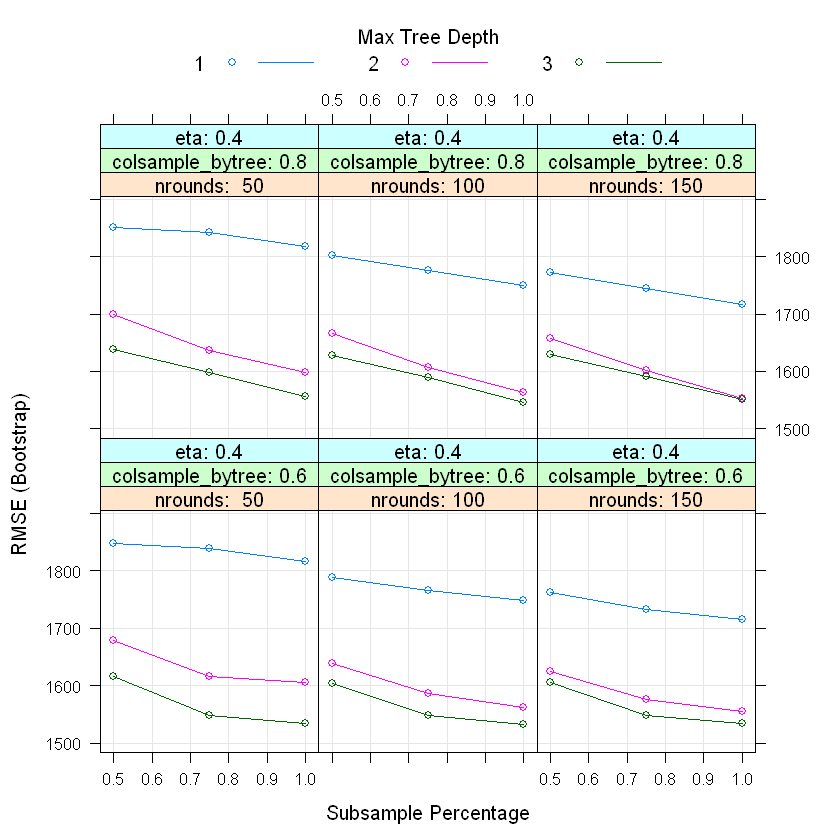

In [70]:
plot(mod_xgb_tuned30)

In [71]:
# Create a new vector in the dataframe with model's predicted values 
test$xgb_tuned30_preds <- predict(mod_xgb_tuned30, test)

In [72]:
# Calculate out-of-sample R2
mod_xgb_tuned30_OSR2 <- OSR2(test$xgb_tuned30_preds, test$BioCNG30daysAhead, train$BioCNG30daysAhead)
mod_xgb_tuned30_OSR2

[1] 0.8256904

### Testing optimal time frame: 20 days

#### Linear model

In [73]:
# Train model
mod_lm20 <- train(BioCNG20daysAhead ~ 
           cum_BioCNG_Output +
           BioCNG_Output +
           PigManure_Input + Cassava_Input + FishWaste_Input + FoodWaste_Input +
           MunFecalRes_Input + TeaWaste_Input + ChickLitter_Input + Baggasse_Input +
           AlcoWaste_Input + MedicineWaste_Input + EnergyGrass_Input + BananaShafts_Input +
           LemonWaste_Input + Percolate_Input + Other_Input + codigestedAmount + total_Input +
           cum_total_Input + cum_PigManure_Input + cum_Cassava_Input + cum_FishWaste_Input +
           cum_FoodWaste_Input + cum_MunFecalRes_Input + cum_TeaWaste_Input + 
           cum_ChickLitter_Input + cum_Baggasse_Input + cum_AlcoWaste_Input +
           cum_MedicineWaste_Input + cum_EnergyGrass_Input + cum_BananaShafts_Input +
           cum_LemonWaste_Input + cum_Percolate_Input + cum_Other_Input,
           method = "lm", metric = "RMSE",
           data = train)

Warning message in predict.lm(modelFit, newdata):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(modelFit, newdata):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(modelFit, newdata):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(modelFit, newdata):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(modelFit, newdata):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(modelFit, newdata):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(modelFit, newdata):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(modelFit, newdata):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(modelFit, newdata):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(modelFit, newdat

In [74]:
# Check model performance
mod_lm20

Linear Regression 

1222 samples
  35 predictor

No pre-processing
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 1222, 1222, 1222, 1222, 1222, 1222, ... 
Resampling results:

  RMSE      Rsquared  MAE     
  1775.124  0.730588  1282.432

Tuning parameter 'intercept' was held constant at a value of TRUE

In [75]:
# Create a new vector in the dataframe with model's predicted values 
test$lm20_preds <- predict(mod_lm20, test)

Warning message in predict.lm(modelFit, newdata):
"prediction from a rank-deficient fit may be misleading"

In [76]:
# Calculate out-of-sample R2
lm20_OSR2 <- OSR2(test$lm20_preds, test$BioCNG20daysAhead, train$BioCNG20daysAhead)
lm20_OSR2

[1] -4.479433

#### Elastic net

In [77]:
#Train model
mod_enet_tuned20 <-train(BioCNG20daysAhead ~ 
           cum_BioCNG_Output +
           BioCNG_Output +
           PigManure_Input + Cassava_Input + FishWaste_Input + FoodWaste_Input +
           MunFecalRes_Input + TeaWaste_Input + ChickLitter_Input + Baggasse_Input +
           AlcoWaste_Input + MedicineWaste_Input + EnergyGrass_Input + BananaShafts_Input +
           LemonWaste_Input + Percolate_Input + Other_Input + codigestedAmount + total_Input +
           cum_total_Input + cum_PigManure_Input + cum_Cassava_Input + cum_FishWaste_Input +
           cum_FoodWaste_Input + cum_MunFecalRes_Input + cum_TeaWaste_Input + 
           cum_ChickLitter_Input + cum_Baggasse_Input + cum_AlcoWaste_Input +
           cum_MedicineWaste_Input + cum_EnergyGrass_Input + cum_BananaShafts_Input +
           cum_LemonWaste_Input + cum_Percolate_Input + cum_Other_Input,
                     data=train,
                     method="glmnet",
                     metric="RMSE",
                     tuneLength = 5)

In [78]:
# Check model performance
mod_enet_tuned20

glmnet 

1222 samples
  35 predictor

No pre-processing
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 1222, 1222, 1222, 1222, 1222, 1222, ... 
Resampling results across tuning parameters:

  alpha  lambda      RMSE      Rsquared   MAE     
  0.100     2.36296  1829.567  0.7122487  1286.189
  0.100    10.96789  1927.177  0.6807421  1358.308
  0.100    50.90843  2037.849  0.6431302  1452.902
  0.100   236.29601  2103.459  0.6200369  1528.370
  0.100  1096.78890  2147.783  0.6076344  1600.174
  0.325     2.36296  1817.710  0.7159456  1278.208
  0.325    10.96789  1927.311  0.6806862  1356.104
  0.325    50.90843  2056.591  0.6365675  1471.304
  0.325   236.29601  2130.777  0.6108996  1566.236
  0.325  1096.78890  2202.137  0.6014263  1683.584
  0.550     2.36296  1809.971  0.7183098  1272.990
  0.550    10.96789  1926.816  0.6808376  1352.801
  0.550    50.90843  2072.302  0.6310700  1489.982
  0.550   236.29601  2139.960  0.6087580  1582.744
  0.550  1096.78890  2265.858  

Warning message:
"Ignoring unknown aesthetics: shape"

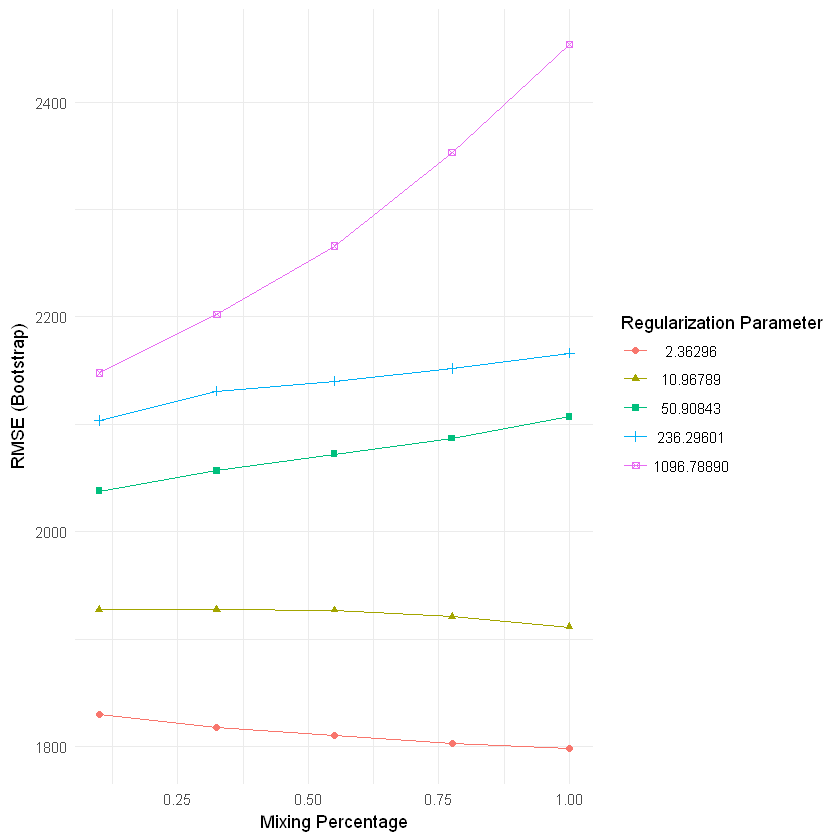

In [79]:
ggplot(mod_enet_tuned20)

In [80]:
# Create a new vector in the dataframe with model's predicted values 
test$enet20_preds <- predict(mod_enet_tuned20, test)

In [81]:
# Calculate out-of-sample R2
enet20_OSR2 <- OSR2(test$enet20_preds, test$BioCNG20daysAhead, train$BioCNG20daysAhead)
enet20_OSR2

[1] -0.394696

#### Random forest

In [82]:
# Train model
mod_rf_tuned20 <- train(BioCNG20daysAhead ~ 
           cum_BioCNG_Output +
           BioCNG_Output +
           PigManure_Input + Cassava_Input + FishWaste_Input + FoodWaste_Input +
           MunFecalRes_Input + TeaWaste_Input + ChickLitter_Input + Baggasse_Input +
           AlcoWaste_Input + MedicineWaste_Input + EnergyGrass_Input + BananaShafts_Input +
           LemonWaste_Input + Percolate_Input + Other_Input + codigestedAmount + total_Input +
           cum_total_Input + cum_PigManure_Input + cum_Cassava_Input + cum_FishWaste_Input +
           cum_FoodWaste_Input + cum_MunFecalRes_Input + cum_TeaWaste_Input + 
           cum_ChickLitter_Input + cum_Baggasse_Input + cum_AlcoWaste_Input +
           cum_MedicineWaste_Input + cum_EnergyGrass_Input + cum_BananaShafts_Input +
           cum_LemonWaste_Input + cum_Percolate_Input + cum_Other_Input,
           method = "ranger", metric = "RMSE", tuneLength = 5,
           data = train)

In [83]:
# Check model performance
mod_rf_tuned20

Random Forest 

1222 samples
  35 predictor

No pre-processing
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 1222, 1222, 1222, 1222, 1222, 1222, ... 
Resampling results across tuning parameters:

  mtry  splitrule   RMSE      Rsquared   MAE      
   2    variance    1599.818  0.7842269  1108.4148
   2    extratrees  1753.825  0.7417791  1238.9743
  10    variance    1378.021  0.8362889   874.4675
  10    extratrees  1355.831  0.8419195   870.4414
  18    variance    1459.429  0.8164990   932.3466
  18    extratrees  1362.860  0.8401690   870.9997
  26    variance    1521.385  0.8007223   980.0919
  26    extratrees  1377.087  0.8367820   880.8914
  35    variance    1571.116  0.7876565  1017.3129
  35    extratrees  1394.783  0.8325306   891.3525

Tuning parameter 'min.node.size' was held constant at a value of 5
RMSE was used to select the optimal model using the smallest value.
The final values used for the model were mtry = 10, splitrule = extratrees
 and min.node.siz

Warning message:
"Ignoring unknown aesthetics: shape"

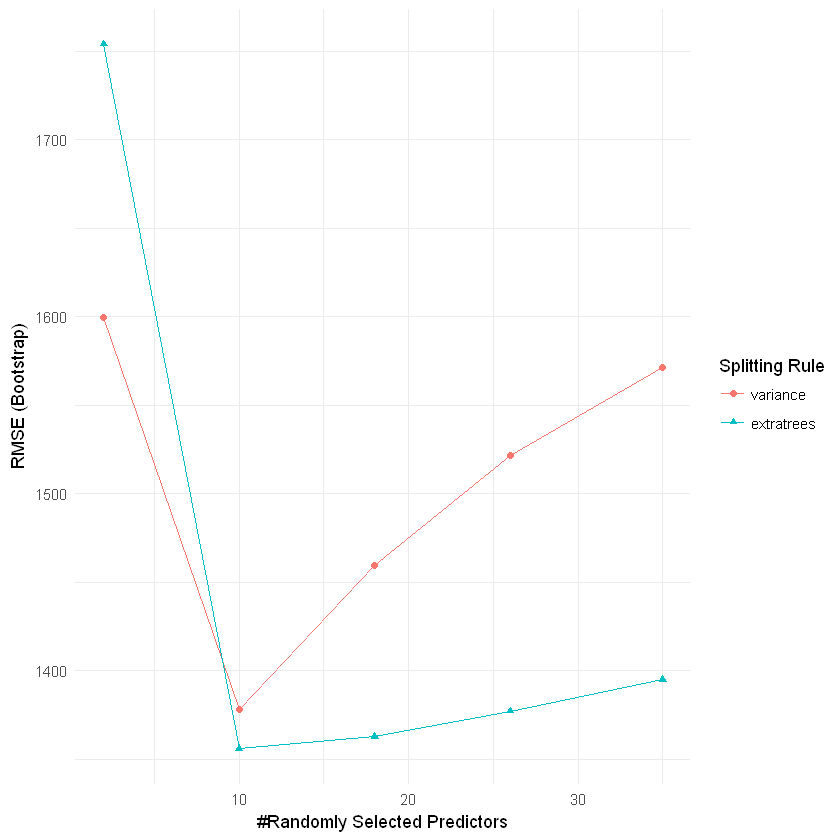

In [84]:
ggplot(mod_rf_tuned20)

In [85]:
# Create a new vector in the dataframe with model's predicted values 
test$rf_tuned20_preds <- predict(mod_rf_tuned20, test)

In [86]:
# Calculate out-of-sample R2
mod_rf_tuned20_OSR2 <- OSR2(test$rf_tuned20_preds, test$BioCNG20daysAhead, train$BioCNG20daysAhead)
mod_rf_tuned20_OSR2

[1] 0.8497562

#### XGBoost

In [87]:
#Train model
mod_xgb_tuned20 <-train(BioCNG20daysAhead ~ 
           cum_BioCNG_Output +
           BioCNG_Output +
           PigManure_Input + Cassava_Input + FishWaste_Input + FoodWaste_Input +
           MunFecalRes_Input + TeaWaste_Input + ChickLitter_Input + Baggasse_Input +
           AlcoWaste_Input + MedicineWaste_Input + EnergyGrass_Input + BananaShafts_Input +
           LemonWaste_Input + Percolate_Input + Other_Input + codigestedAmount + total_Input +
           cum_total_Input + cum_PigManure_Input + cum_Cassava_Input + cum_FishWaste_Input +
           cum_FoodWaste_Input + cum_MunFecalRes_Input + cum_TeaWaste_Input + 
           cum_ChickLitter_Input + cum_Baggasse_Input + cum_AlcoWaste_Input +
           cum_MedicineWaste_Input + cum_EnergyGrass_Input + cum_BananaShafts_Input +
           cum_LemonWaste_Input + cum_Percolate_Input + cum_Other_Input,
                     data=train,
                     method="xgbTree",
                     verbose=F,
                     metric="RMSE",
                     tuneLength = 3)

In [88]:
# Check model performance
mod_xgb_tuned20

eXtreme Gradient Boosting 

1222 samples
  35 predictor

No pre-processing
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 1222, 1222, 1222, 1222, 1222, 1222, ... 
Resampling results across tuning parameters:

  eta  max_depth  colsample_bytree  subsample  nrounds  RMSE      Rsquared 
  0.3  1          0.6               0.50        50      1920.416  0.6863462
  0.3  1          0.6               0.50       100      1846.967  0.7095201
  0.3  1          0.6               0.50       150      1813.859  0.7202286
  0.3  1          0.6               0.75        50      1899.920  0.6932997
  0.3  1          0.6               0.75       100      1832.591  0.7145072
  0.3  1          0.6               0.75       150      1789.457  0.7274868
  0.3  1          0.6               1.00        50      1892.543  0.6957963
  0.3  1          0.6               1.00       100      1815.961  0.7198164
  0.3  1          0.6               1.00       150      1775.550  0.7319929
  0.3  1         

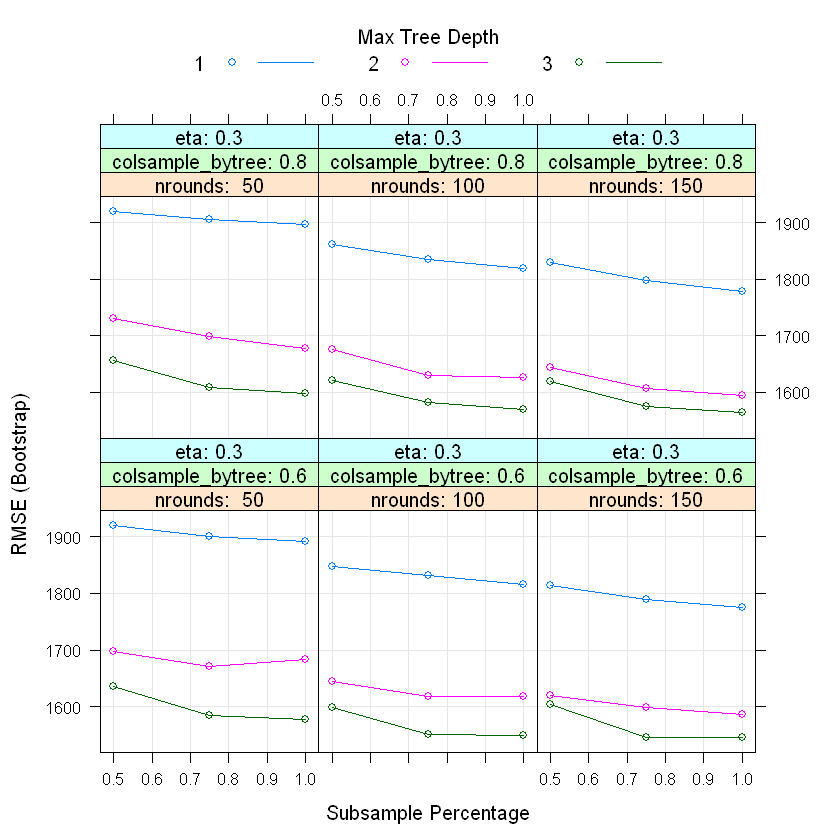

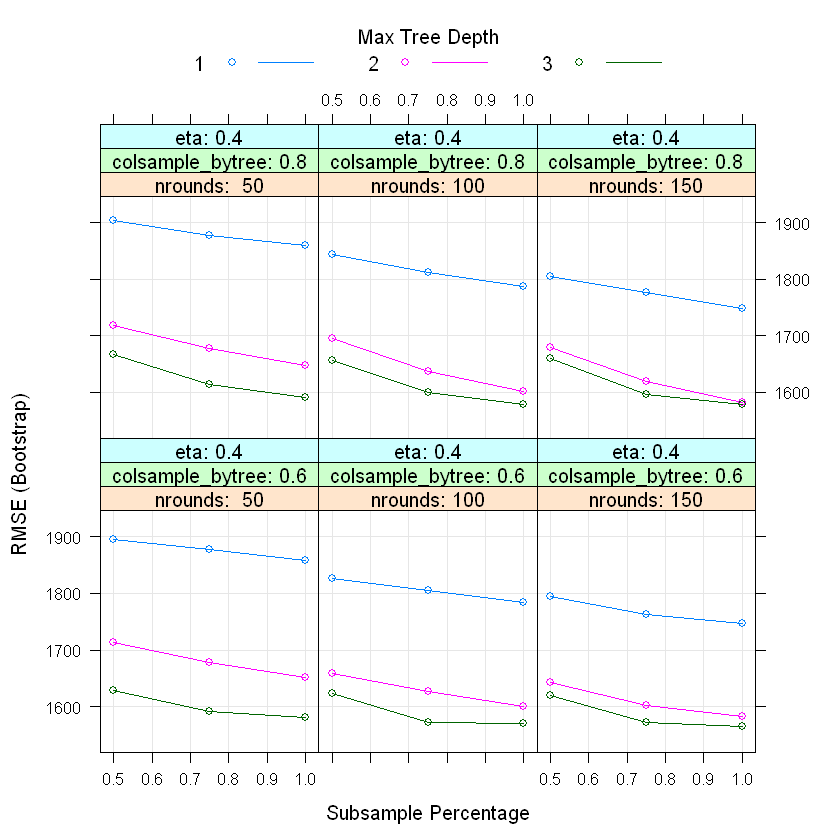

In [89]:
plot(mod_xgb_tuned20)

In [90]:
# Create a new vector in the dataframe with model's predicted values 
test$xgb_tuned20_preds <- predict(mod_xgb_tuned20, test)

In [91]:
# Calculate out-of-sample R2
mod_xgb_tuned20_OSR2 <- OSR2(test$xgb_tuned20_preds, test$BioCNG20daysAhead, train$BioCNG20daysAhead)
mod_xgb_tuned20_OSR2

[1] 0.8490203

### Testing optimal time frame: 10 days

#### Linear model

In [92]:
# Train model
mod_lm10 <- train(BioCNG10daysAhead ~ 
           cum_BioCNG_Output +
           BioCNG_Output +
           PigManure_Input + Cassava_Input + FishWaste_Input + FoodWaste_Input +
           MunFecalRes_Input + TeaWaste_Input + ChickLitter_Input + Baggasse_Input +
           AlcoWaste_Input + MedicineWaste_Input + EnergyGrass_Input + BananaShafts_Input +
           LemonWaste_Input + Percolate_Input + Other_Input + codigestedAmount + total_Input +
           cum_total_Input + cum_PigManure_Input + cum_Cassava_Input + cum_FishWaste_Input +
           cum_FoodWaste_Input + cum_MunFecalRes_Input + cum_TeaWaste_Input + 
           cum_ChickLitter_Input + cum_Baggasse_Input + cum_AlcoWaste_Input +
           cum_MedicineWaste_Input + cum_EnergyGrass_Input + cum_BananaShafts_Input +
           cum_LemonWaste_Input + cum_Percolate_Input + cum_Other_Input,
           method = "lm", metric = "RMSE",
           data = train)

Warning message in predict.lm(modelFit, newdata):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(modelFit, newdata):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(modelFit, newdata):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(modelFit, newdata):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(modelFit, newdata):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(modelFit, newdata):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(modelFit, newdata):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(modelFit, newdata):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(modelFit, newdata):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(modelFit, newdat

In [93]:
# Check model performance
mod_lm10

Linear Regression 

1222 samples
  35 predictor

No pre-processing
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 1222, 1222, 1222, 1222, 1222, 1222, ... 
Resampling results:

  RMSE      Rsquared  MAE     
  1719.272  0.736002  1187.339

Tuning parameter 'intercept' was held constant at a value of TRUE

In [94]:
# Create a new vector in the dataframe with model's predicted values 
test$lm10_preds <- predict(mod_lm10, test)

Warning message in predict.lm(modelFit, newdata):
"prediction from a rank-deficient fit may be misleading"

In [95]:
# Calculate out-of-sample R2
lm10_OSR2 <- OSR2(test$lm10_preds, test$BioCNG10daysAhead, train$BioCNG10daysAhead)
lm10_OSR2

[1] -0.9196106

#### Elastic net

In [96]:
#Train model
mod_enet_tuned10 <-train(BioCNG10daysAhead ~ 
           cum_BioCNG_Output +
           BioCNG_Output +
           PigManure_Input + Cassava_Input + FishWaste_Input + FoodWaste_Input +
           MunFecalRes_Input + TeaWaste_Input + ChickLitter_Input + Baggasse_Input +
           AlcoWaste_Input + MedicineWaste_Input + EnergyGrass_Input + BananaShafts_Input +
           LemonWaste_Input + Percolate_Input + Other_Input + codigestedAmount + total_Input +
           cum_total_Input + cum_PigManure_Input + cum_Cassava_Input + cum_FishWaste_Input +
           cum_FoodWaste_Input + cum_MunFecalRes_Input + cum_TeaWaste_Input + 
           cum_ChickLitter_Input + cum_Baggasse_Input + cum_AlcoWaste_Input +
           cum_MedicineWaste_Input + cum_EnergyGrass_Input + cum_BananaShafts_Input +
           cum_LemonWaste_Input + cum_Percolate_Input + cum_Other_Input,
                     data=train,
                     method="glmnet",
                     metric="RMSE",
                     tuneLength = 5)

In [97]:
# Check model performance
mod_enet_tuned10

glmnet 

1222 samples
  35 predictor

No pre-processing
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 1222, 1222, 1222, 1222, 1222, 1222, ... 
Resampling results across tuning parameters:

  alpha  lambda       RMSE      Rsquared   MAE     
  0.100     2.407281  1775.284  0.7218732  1229.613
  0.100    11.173610  1822.584  0.7070926  1269.592
  0.100    51.863304  1867.352  0.6926945  1316.633
  0.100   240.728134  1904.214  0.6807968  1368.179
  0.100  1117.361020  1954.414  0.6691137  1443.646
  0.325     2.407281  1770.566  0.7233456  1225.855
  0.325    11.173610  1825.857  0.7060272  1272.096
  0.325    51.863304  1875.039  0.6902069  1328.711
  0.325   240.728134  1928.486  0.6734979  1400.942
  0.325  1117.361020  2028.769  0.6597089  1536.906
  0.550     2.407281  1769.168  0.7238012  1224.884
  0.550    11.173610  1830.502  0.7045210  1275.250
  0.550    51.863304  1884.997  0.6869826  1343.133
  0.550   240.728134  1936.131  0.6724425  1415.158
  0.550  1117.36

Warning message:
"Ignoring unknown aesthetics: shape"

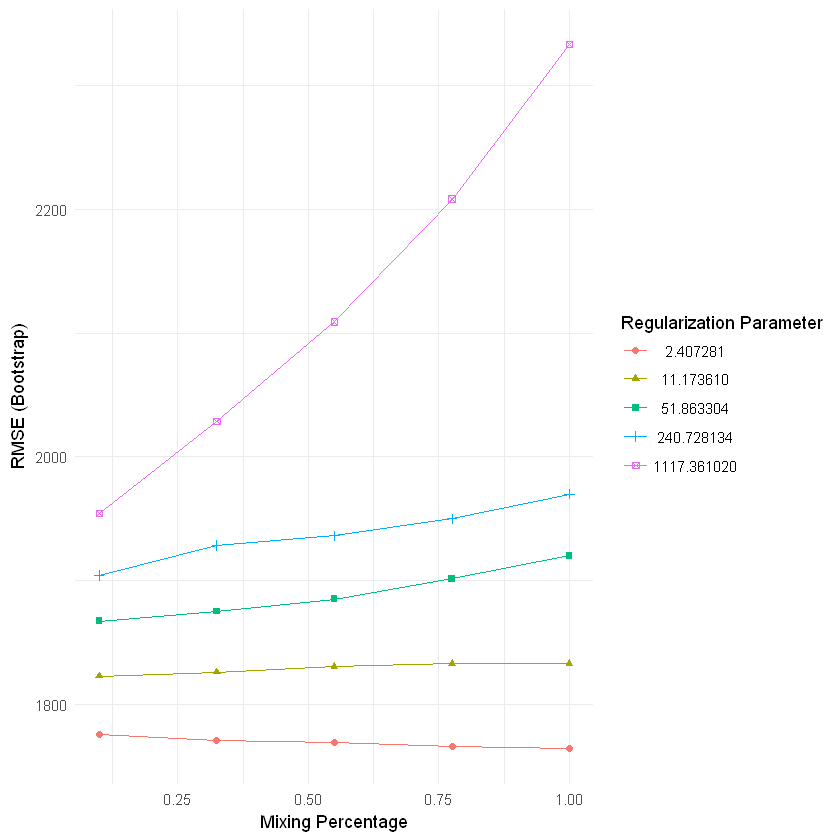

In [98]:
ggplot(mod_enet_tuned10)

In [99]:
# Create a new vector in the dataframe with model's predicted values 
test$enet10_preds <- predict(mod_enet_tuned10, test)

In [100]:
# Calculate out-of-sample R2
enet10_OSR2 <- OSR2(test$enet10_preds, test$BioCNG10daysAhead, train$BioCNG10daysAhead)
enet10_OSR2

[1] -0.07571525

#### Random forest

In [101]:
# Train model
mod_rf_tuned10 <- train(BioCNG10daysAhead ~ 
           cum_BioCNG_Output +
           BioCNG_Output +
           PigManure_Input + Cassava_Input + FishWaste_Input + FoodWaste_Input +
           MunFecalRes_Input + TeaWaste_Input + ChickLitter_Input + Baggasse_Input +
           AlcoWaste_Input + MedicineWaste_Input + EnergyGrass_Input + BananaShafts_Input +
           LemonWaste_Input + Percolate_Input + Other_Input + codigestedAmount + total_Input +
           cum_total_Input + cum_PigManure_Input + cum_Cassava_Input + cum_FishWaste_Input +
           cum_FoodWaste_Input + cum_MunFecalRes_Input + cum_TeaWaste_Input + 
           cum_ChickLitter_Input + cum_Baggasse_Input + cum_AlcoWaste_Input +
           cum_MedicineWaste_Input + cum_EnergyGrass_Input + cum_BananaShafts_Input +
           cum_LemonWaste_Input + cum_Percolate_Input + cum_Other_Input,
           method = "ranger", metric = "RMSE", tuneLength = 5,
           data = train)

In [102]:
# Check model performance
mod_rf_tuned10

Random Forest 

1222 samples
  35 predictor

No pre-processing
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 1222, 1222, 1222, 1222, 1222, 1222, ... 
Resampling results across tuning parameters:

  mtry  splitrule   RMSE      Rsquared   MAE      
   2    variance    1583.795  0.7809358  1090.3012
   2    extratrees  1716.636  0.7441308  1203.5542
  10    variance    1419.511  0.8212053   917.3050
  10    extratrees  1437.301  0.8167755   934.0389
  18    variance    1497.695  0.8008388   981.0672
  18    extratrees  1458.709  0.8111772   949.6309
  26    variance    1556.293  0.7849188  1027.9469
  26    extratrees  1476.422  0.8065354   964.4798
  35    variance    1610.814  0.7695945  1066.2814
  35    extratrees  1493.326  0.8020850   978.9078

Tuning parameter 'min.node.size' was held constant at a value of 5
RMSE was used to select the optimal model using the smallest value.
The final values used for the model were mtry = 10, splitrule = variance
 and min.node.size 

Warning message:
"Ignoring unknown aesthetics: shape"

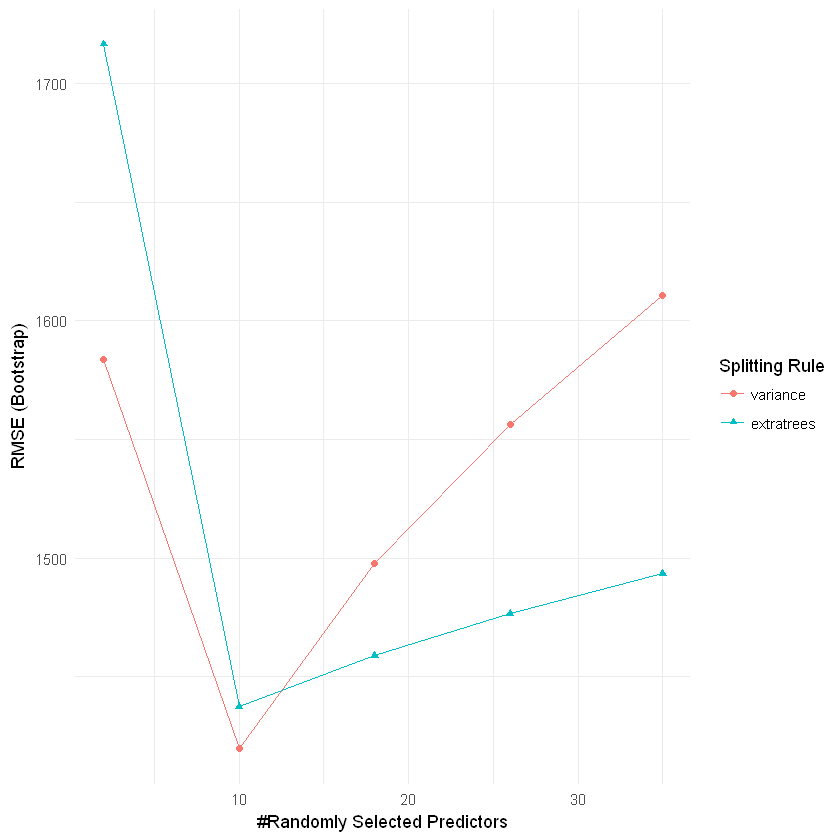

In [103]:
ggplot(mod_rf_tuned10)

In [104]:
# Create a new vector in the dataframe with model's predicted values 
test$rf_tuned10_preds <- predict(mod_rf_tuned10, test)

In [105]:
# Calculate out-of-sample R2
mod_rf_tuned10_OSR2 <- OSR2(test$rf_tuned10_preds, test$BioCNG10daysAhead, train$BioCNG10daysAhead)
mod_rf_tuned10_OSR2

[1] 0.8518041

#### XGBoost

In [106]:
#Train model
mod_xgb_tuned10 <-train(BioCNG10daysAhead ~ 
           cum_BioCNG_Output +
           BioCNG_Output +
           PigManure_Input + Cassava_Input + FishWaste_Input + FoodWaste_Input +
           MunFecalRes_Input + TeaWaste_Input + ChickLitter_Input + Baggasse_Input +
           AlcoWaste_Input + MedicineWaste_Input + EnergyGrass_Input + BananaShafts_Input +
           LemonWaste_Input + Percolate_Input + Other_Input + codigestedAmount + total_Input +
           cum_total_Input + cum_PigManure_Input + cum_Cassava_Input + cum_FishWaste_Input +
           cum_FoodWaste_Input + cum_MunFecalRes_Input + cum_TeaWaste_Input + 
           cum_ChickLitter_Input + cum_Baggasse_Input + cum_AlcoWaste_Input +
           cum_MedicineWaste_Input + cum_EnergyGrass_Input + cum_BananaShafts_Input +
           cum_LemonWaste_Input + cum_Percolate_Input + cum_Other_Input,
                     data=train,
                     method="xgbTree",
                     verbose=F,
                     metric="RMSE",
                     tuneLength = 3)

In [107]:
# Check model performance
mod_xgb_tuned10

eXtreme Gradient Boosting 

1222 samples
  35 predictor

No pre-processing
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 1222, 1222, 1222, 1222, 1222, 1222, ... 
Resampling results across tuning parameters:

  eta  max_depth  colsample_bytree  subsample  nrounds  RMSE      Rsquared 
  0.3  1          0.6               0.50        50      1793.087  0.7085491
  0.3  1          0.6               0.50       100      1765.024  0.7177013
  0.3  1          0.6               0.50       150      1742.609  0.7252527
  0.3  1          0.6               0.75        50      1781.067  0.7123513
  0.3  1          0.6               0.75       100      1742.532  0.7245862
  0.3  1          0.6               0.75       150      1725.881  0.7299958
  0.3  1          0.6               1.00        50      1776.602  0.7137057
  0.3  1          0.6               1.00       100      1738.887  0.7256785
  0.3  1          0.6               1.00       150      1713.318  0.7336996
  0.3  1         

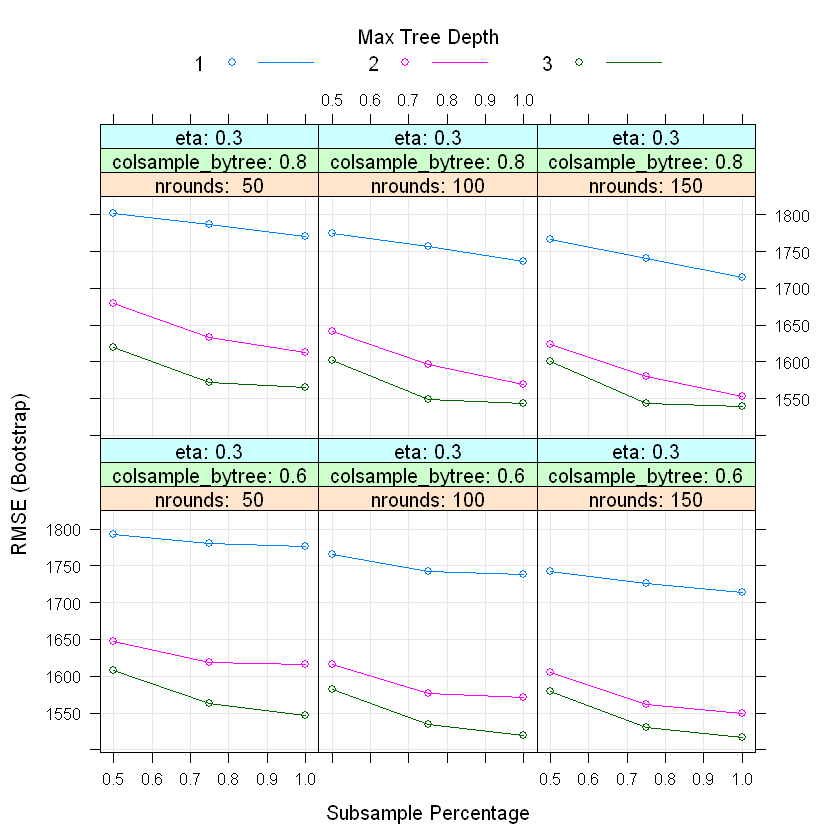

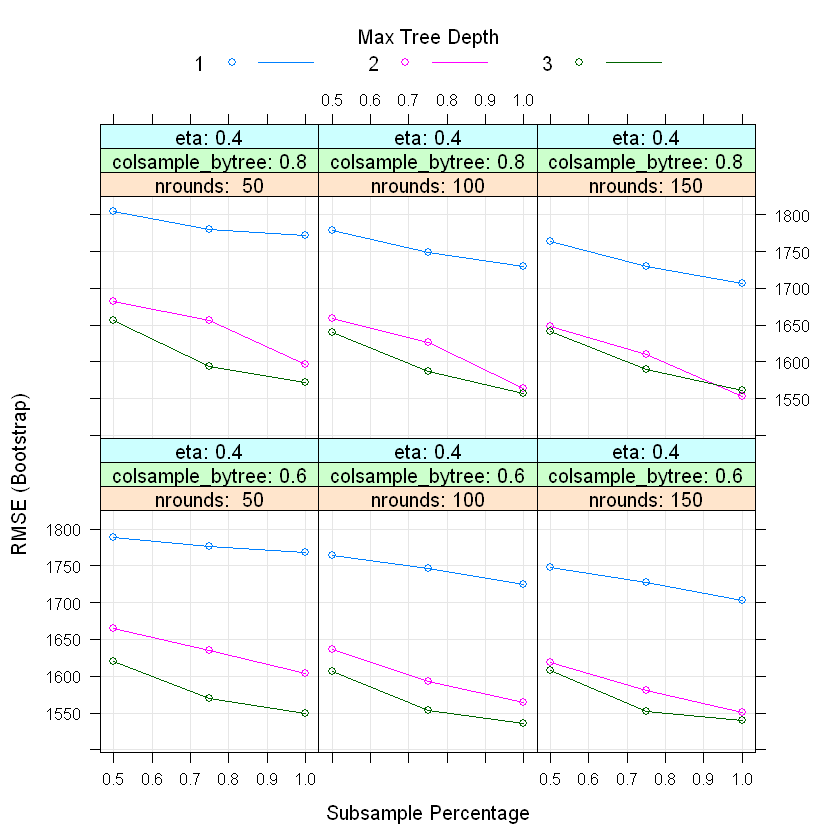

In [108]:
plot(mod_xgb_tuned10)

In [109]:
# Create a new vector in the dataframe with model's predicted values 
test$xgb_tuned10_preds <- predict(mod_xgb_tuned10, test)

In [110]:
# Calculate out-of-sample R2
mod_xgb_tuned10_OSR2 <- OSR2(test$xgb_tuned10_preds, test$BioCNG10daysAhead, train$BioCNG10daysAhead)
mod_xgb_tuned10_OSR2

[1] 0.8354809

### Testing optimal time frame: 5 days

#### Linear model

In [111]:
# Train model
mod_lm5 <- train(BioCNG5daysAhead ~ 
           cum_BioCNG_Output +
           BioCNG_Output +
           PigManure_Input + Cassava_Input + FishWaste_Input + FoodWaste_Input +
           MunFecalRes_Input + TeaWaste_Input + ChickLitter_Input + Baggasse_Input +
           AlcoWaste_Input + MedicineWaste_Input + EnergyGrass_Input + BananaShafts_Input +
           LemonWaste_Input + Percolate_Input + Other_Input + codigestedAmount + total_Input +
           cum_total_Input + cum_PigManure_Input + cum_Cassava_Input + cum_FishWaste_Input +
           cum_FoodWaste_Input + cum_MunFecalRes_Input + cum_TeaWaste_Input + 
           cum_ChickLitter_Input + cum_Baggasse_Input + cum_AlcoWaste_Input +
           cum_MedicineWaste_Input + cum_EnergyGrass_Input + cum_BananaShafts_Input +
           cum_LemonWaste_Input + cum_Percolate_Input + cum_Other_Input,
           method = "lm", metric = "RMSE",
           data = train)

Warning message in predict.lm(modelFit, newdata):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(modelFit, newdata):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(modelFit, newdata):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(modelFit, newdata):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(modelFit, newdata):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(modelFit, newdata):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(modelFit, newdata):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(modelFit, newdata):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(modelFit, newdata):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(modelFit, newdat

In [112]:
# Check model performance
mod_lm5

Linear Regression 

1222 samples
  35 predictor

No pre-processing
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 1222, 1222, 1222, 1222, 1222, 1222, ... 
Resampling results:

  RMSE      Rsquared   MAE     
  1608.642  0.7669982  1073.166

Tuning parameter 'intercept' was held constant at a value of TRUE

In [113]:
# Create a new vector in the dataframe with model's predicted values 
test$lm5_preds <- predict(mod_lm5, test)

Warning message in predict.lm(modelFit, newdata):
"prediction from a rank-deficient fit may be misleading"

In [114]:
# Calculate out-of-sample R2
lm5_OSR2 <- OSR2(test$lm5_preds, test$BioCNG5daysAhead, train$BioCNG5daysAhead)
lm5_OSR2

[1] -0.5347185

#### Elastic net

In [115]:
#Train model
mod_enet_tuned5 <-train(BioCNG5daysAhead ~ 
           cum_BioCNG_Output +
           BioCNG_Output +
           PigManure_Input + Cassava_Input + FishWaste_Input + FoodWaste_Input +
           MunFecalRes_Input + TeaWaste_Input + ChickLitter_Input + Baggasse_Input +
           AlcoWaste_Input + MedicineWaste_Input + EnergyGrass_Input + BananaShafts_Input +
           LemonWaste_Input + Percolate_Input + Other_Input + codigestedAmount + total_Input +
           cum_total_Input + cum_PigManure_Input + cum_Cassava_Input + cum_FishWaste_Input +
           cum_FoodWaste_Input + cum_MunFecalRes_Input + cum_TeaWaste_Input + 
           cum_ChickLitter_Input + cum_Baggasse_Input + cum_AlcoWaste_Input +
           cum_MedicineWaste_Input + cum_EnergyGrass_Input + cum_BananaShafts_Input +
           cum_LemonWaste_Input + cum_Percolate_Input + cum_Other_Input,
                     data=train,
                     method="glmnet",
                     metric="RMSE",
                     tuneLength = 5)

In [116]:
# Check model performance
mod_enet_tuned5

glmnet 

1222 samples
  35 predictor

No pre-processing
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 1222, 1222, 1222, 1222, 1222, 1222, ... 
Resampling results across tuning parameters:

  alpha  lambda       RMSE      Rsquared   MAE     
  0.100     2.559898  1618.602  0.7624916  1090.917
  0.100    11.881992  1633.928  0.7579164  1106.821
  0.100    55.151324  1651.497  0.7526189  1134.304
  0.100   255.989767  1675.817  0.7455919  1183.797
  0.100  1188.199246  1730.066  0.7366953  1271.347
  0.325     2.559898  1617.902  0.7626699  1089.903
  0.325    11.881992  1635.628  0.7573747  1108.837
  0.325    55.151324  1660.622  0.7498793  1152.387
  0.325   255.989767  1694.863  0.7409722  1212.113
  0.325  1188.199246  1827.045  0.7266200  1377.417
  0.550     2.559898  1617.518  0.7627669  1089.403
  0.550    11.881992  1635.856  0.7572545  1110.354
  0.550    55.151324  1673.453  0.7460076  1172.408
  0.550   255.989767  1715.762  0.7360780  1237.351
  0.550  1188.19

Warning message:
"Ignoring unknown aesthetics: shape"

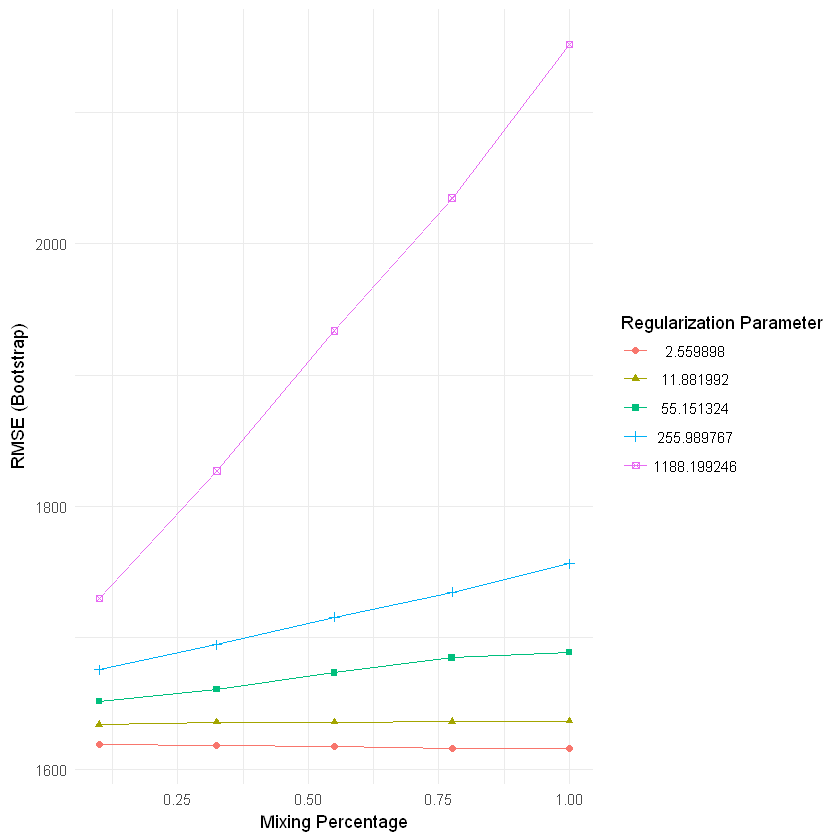

In [117]:
ggplot(mod_enet_tuned5)

In [118]:
# Create a new vector in the dataframe with model's predicted values 
test$enet5_preds <- predict(mod_enet_tuned5, test)

In [119]:
# Calculate out-of-sample R2
enet5_OSR2 <- OSR2(test$enet5_preds, test$BioCNG5daysAhead, train$BioCNG5daysAhead)
enet5_OSR2

[1] 0.5763455

#### Random forest

In [120]:
# Train model
mod_rf_tuned5 <- train(BioCNG5daysAhead ~ 
           cum_BioCNG_Output +
           BioCNG_Output +
           PigManure_Input + Cassava_Input + FishWaste_Input + FoodWaste_Input +
           MunFecalRes_Input + TeaWaste_Input + ChickLitter_Input + Baggasse_Input +
           AlcoWaste_Input + MedicineWaste_Input + EnergyGrass_Input + BananaShafts_Input +
           LemonWaste_Input + Percolate_Input + Other_Input + codigestedAmount + total_Input +
           cum_total_Input + cum_PigManure_Input + cum_Cassava_Input + cum_FishWaste_Input +
           cum_FoodWaste_Input + cum_MunFecalRes_Input + cum_TeaWaste_Input + 
           cum_ChickLitter_Input + cum_Baggasse_Input + cum_AlcoWaste_Input +
           cum_MedicineWaste_Input + cum_EnergyGrass_Input + cum_BananaShafts_Input +
           cum_LemonWaste_Input + cum_Percolate_Input + cum_Other_Input,
           method = "ranger", metric = "RMSE", tuneLength = 5,
           data = train)

In [121]:
# Check model performance
mod_rf_tuned5

Random Forest 

1222 samples
  35 predictor

No pre-processing
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 1222, 1222, 1222, 1222, 1222, 1222, ... 
Resampling results across tuning parameters:

  mtry  splitrule   RMSE      Rsquared   MAE      
   2    variance    1467.715  0.8111394  1013.9669
   2    extratrees  1609.537  0.7761583  1137.3495
  10    variance    1400.439  0.8229389   910.3434
  10    extratrees  1382.536  0.8278814   898.7023
  18    variance    1476.574  0.8030837   968.4765
  18    extratrees  1411.082  0.8206022   920.1756
  26    variance    1519.839  0.7913127  1002.5363
  26    extratrees  1430.898  0.8154779   934.7943
  35    variance    1549.521  0.7830389  1024.1918
  35    extratrees  1445.624  0.8116314   946.8144

Tuning parameter 'min.node.size' was held constant at a value of 5
RMSE was used to select the optimal model using the smallest value.
The final values used for the model were mtry = 10, splitrule = extratrees
 and min.node.siz

Warning message:
"Ignoring unknown aesthetics: shape"

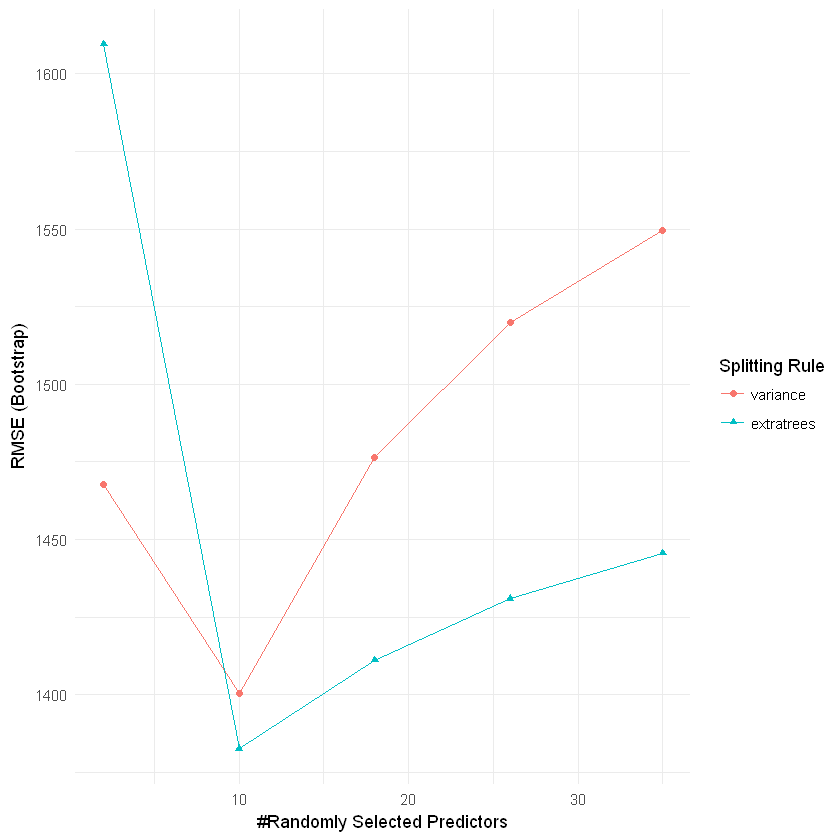

In [122]:
ggplot(mod_rf_tuned5)

In [123]:
# Create a new vector in the dataframe with model's predicted values 
test$rf_tuned5_preds <- predict(mod_rf_tuned5, test)

In [124]:
# Calculate out-of-sample R2
mod_rf_tuned5_OSR2 <- OSR2(test$rf_tuned5_preds, test$BioCNG5daysAhead, train$BioCNG5daysAhead)
mod_rf_tuned5_OSR2

[1] 0.8489727

#### XGBoost

In [125]:
#Train model
mod_xgb_tuned5 <-train(BioCNG5daysAhead ~ 
           cum_BioCNG_Output +
           BioCNG_Output +
           PigManure_Input + Cassava_Input + FishWaste_Input + FoodWaste_Input +
           MunFecalRes_Input + TeaWaste_Input + ChickLitter_Input + Baggasse_Input +
           AlcoWaste_Input + MedicineWaste_Input + EnergyGrass_Input + BananaShafts_Input +
           LemonWaste_Input + Percolate_Input + Other_Input + codigestedAmount + total_Input +
           cum_total_Input + cum_PigManure_Input + cum_Cassava_Input + cum_FishWaste_Input +
           cum_FoodWaste_Input + cum_MunFecalRes_Input + cum_TeaWaste_Input + 
           cum_ChickLitter_Input + cum_Baggasse_Input + cum_AlcoWaste_Input +
           cum_MedicineWaste_Input + cum_EnergyGrass_Input + cum_BananaShafts_Input +
           cum_LemonWaste_Input + cum_Percolate_Input + cum_Other_Input,
                     data=train,
                     method="xgbTree",
                     verbose=F,
                     metric="RMSE",
                     tuneLength = 3)

In [126]:
# Check model performance
mod_xgb_tuned5

eXtreme Gradient Boosting 

1222 samples
  35 predictor

No pre-processing
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 1222, 1222, 1222, 1222, 1222, 1222, ... 
Resampling results across tuning parameters:

  eta  max_depth  colsample_bytree  subsample  nrounds  RMSE      Rsquared 
  0.3  1          0.6               0.50        50      1666.213  0.7512258
  0.3  1          0.6               0.50       100      1666.102  0.7517602
  0.3  1          0.6               0.50       150      1668.140  0.7513631
  0.3  1          0.6               0.75        50      1650.320  0.7552392
  0.3  1          0.6               0.75       100      1651.886  0.7552354
  0.3  1          0.6               0.75       150      1653.858  0.7548833
  0.3  1          0.6               1.00        50      1652.205  0.7549058
  0.3  1          0.6               1.00       100      1648.159  0.7563738
  0.3  1          0.6               1.00       150      1648.499  0.7564146
  0.3  1         

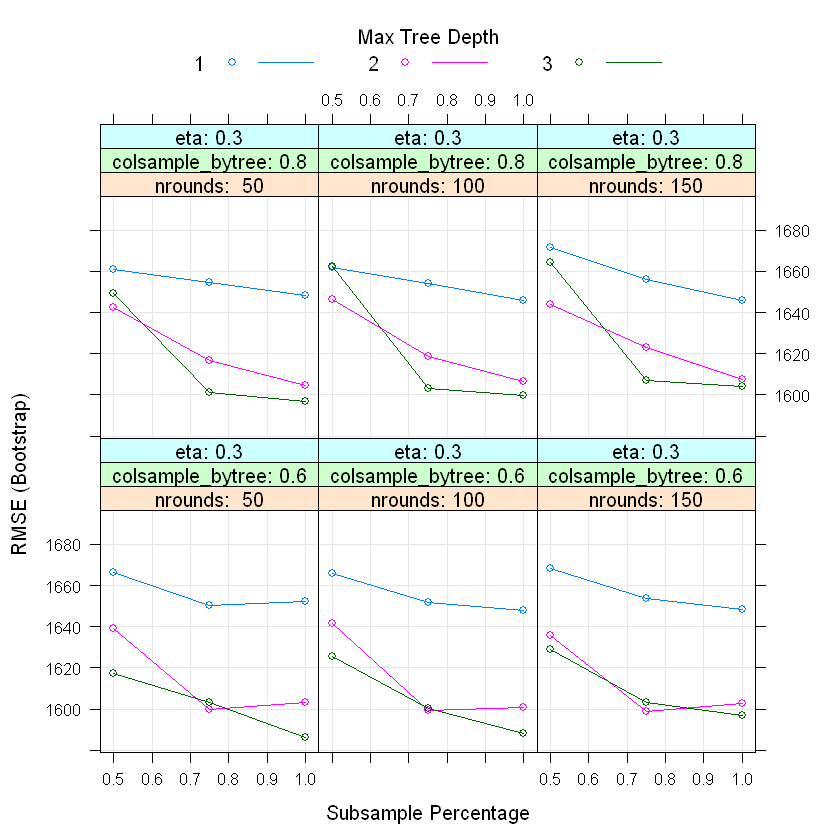

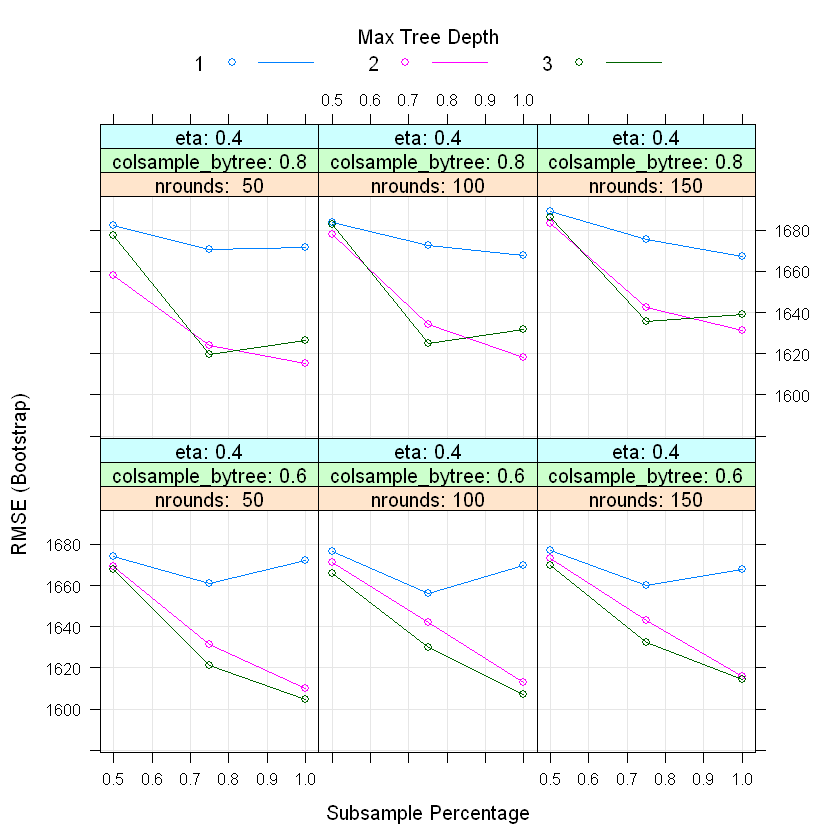

In [127]:
plot(mod_xgb_tuned5)

In [128]:
# Create a new vector in the dataframe with model's predicted values 
test$xgb_tuned5_preds <- predict(mod_xgb_tuned5, test)

In [129]:
# Calculate out-of-sample R2
mod_xgb_tuned5_OSR2 <- OSR2(test$xgb_tuned5_preds, test$BioCNG5daysAhead, train$BioCNG5daysAhead)
mod_xgb_tuned5_OSR2

[1] 0.8588548

### Testing optimal time frame: 3 days

#### Linear model

In [130]:
# Train model
mod_lm3 <- train(BioCNG3daysAhead ~ 
           cum_BioCNG_Output +
           BioCNG_Output +
           PigManure_Input + Cassava_Input + FishWaste_Input + FoodWaste_Input +
           MunFecalRes_Input + TeaWaste_Input + ChickLitter_Input + Baggasse_Input +
           AlcoWaste_Input + MedicineWaste_Input + EnergyGrass_Input + BananaShafts_Input +
           LemonWaste_Input + Percolate_Input + Other_Input + codigestedAmount + total_Input +
           cum_total_Input + cum_PigManure_Input + cum_Cassava_Input + cum_FishWaste_Input +
           cum_FoodWaste_Input + cum_MunFecalRes_Input + cum_TeaWaste_Input + 
           cum_ChickLitter_Input + cum_Baggasse_Input + cum_AlcoWaste_Input +
           cum_MedicineWaste_Input + cum_EnergyGrass_Input + cum_BananaShafts_Input +
           cum_LemonWaste_Input + cum_Percolate_Input + cum_Other_Input,
           method = "lm", metric = "RMSE",
           data = train)

Warning message in predict.lm(modelFit, newdata):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(modelFit, newdata):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(modelFit, newdata):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(modelFit, newdata):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(modelFit, newdata):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(modelFit, newdata):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(modelFit, newdata):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(modelFit, newdata):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(modelFit, newdata):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(modelFit, newdat

In [131]:
# Check model performance
mod_lm3

Linear Regression 

1222 samples
  35 predictor

No pre-processing
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 1222, 1222, 1222, 1222, 1222, 1222, ... 
Resampling results:

  RMSE      Rsquared   MAE   
  1551.808  0.7844012  1014.1

Tuning parameter 'intercept' was held constant at a value of TRUE

In [132]:
# Create a new vector in the dataframe with model's predicted values 
test$lm3_preds <- predict(mod_lm3, test)

Warning message in predict.lm(modelFit, newdata):
"prediction from a rank-deficient fit may be misleading"

In [133]:
# Calculate out-of-sample R2
lm3_OSR2 <- OSR2(test$lm3_preds, test$BioCNG3daysAhead, train$BioCNG3daysAhead)
lm3_OSR2

[1] -2.74353

#### Elastic net

In [134]:
#Train model
mod_enet_tuned3 <-train(BioCNG3daysAhead ~ 
           cum_BioCNG_Output +
           BioCNG_Output +
           PigManure_Input + Cassava_Input + FishWaste_Input + FoodWaste_Input +
           MunFecalRes_Input + TeaWaste_Input + ChickLitter_Input + Baggasse_Input +
           AlcoWaste_Input + MedicineWaste_Input + EnergyGrass_Input + BananaShafts_Input +
           LemonWaste_Input + Percolate_Input + Other_Input + codigestedAmount + total_Input +
           cum_total_Input + cum_PigManure_Input + cum_Cassava_Input + cum_FishWaste_Input +
           cum_FoodWaste_Input + cum_MunFecalRes_Input + cum_TeaWaste_Input + 
           cum_ChickLitter_Input + cum_Baggasse_Input + cum_AlcoWaste_Input +
           cum_MedicineWaste_Input + cum_EnergyGrass_Input + cum_BananaShafts_Input +
           cum_LemonWaste_Input + cum_Percolate_Input + cum_Other_Input,
                     data=train,
                     method="glmnet",
                     metric="RMSE",
                     tuneLength = 5)

In [135]:
# Check model performance
mod_enet_tuned3

glmnet 

1222 samples
  35 predictor

No pre-processing
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 1222, 1222, 1222, 1222, 1222, 1222, ... 
Resampling results across tuning parameters:

  alpha  lambda       RMSE      Rsquared   MAE     
  0.100     2.604819  1550.352  0.7845283  1009.096
  0.100    12.090500  1557.919  0.7823514  1012.615
  0.100    56.119128  1572.943  0.7780331  1031.106
  0.100   260.481917  1602.782  0.7698565  1079.479
  0.100  1209.049958  1654.903  0.7632835  1171.291
  0.325     2.604819  1549.975  0.7846093  1008.242
  0.325    12.090500  1559.076  0.7820050  1013.443
  0.325    56.119128  1589.652  0.7733373  1050.559
  0.325   260.481917  1617.090  0.7668329  1099.446
  0.325  1209.049958  1762.713  0.7530667  1298.228
  0.550     2.604819  1549.906  0.7846330  1007.579
  0.550    12.090500  1559.999  0.7817133  1014.632
  0.550    56.119128  1605.170  0.7689085  1071.548
  0.550   260.481917  1638.012  0.7622288  1123.612
  0.550  1209.04

Warning message:
"Ignoring unknown aesthetics: shape"

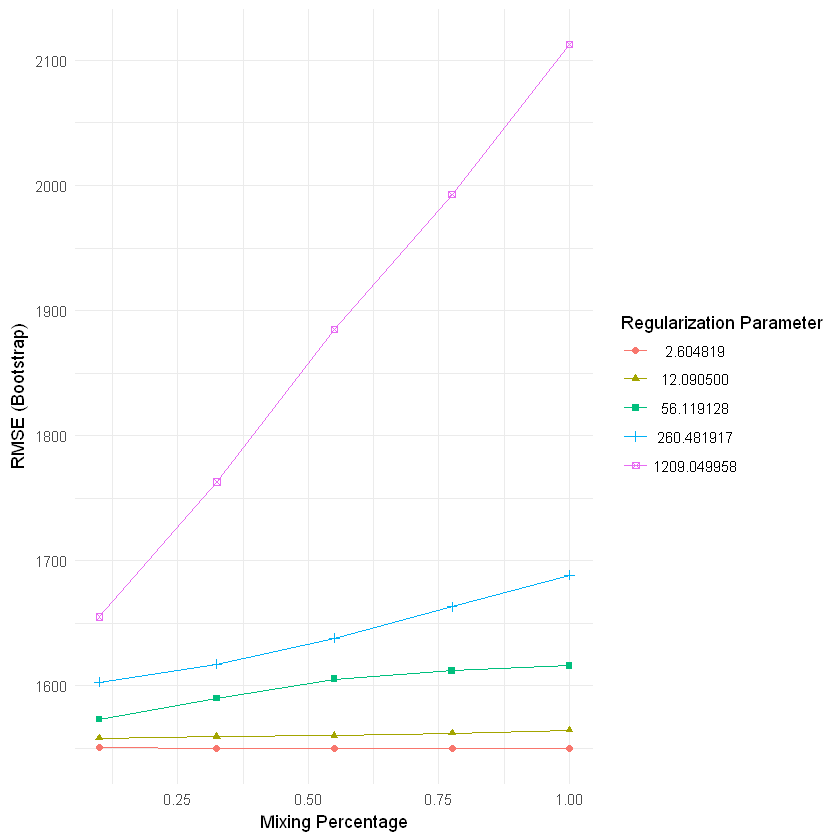

In [136]:
ggplot(mod_enet_tuned3)

In [137]:
# Create a new vector in the dataframe with model's predicted values 
test$enet3_preds <- predict(mod_enet_tuned3, test)

In [138]:
# Calculate out-of-sample R2
enet3_OSR2 <- OSR2(test$enet3_preds, test$BioCNG3daysAhead, train$BioCNG3daysAhead)
enet3_OSR2

[1] 0.4562635

#### Random forest

In [139]:
# Train model
mod_rf_tuned3 <- train(BioCNG3daysAhead ~ 
           cum_BioCNG_Output +
           BioCNG_Output +
           PigManure_Input + Cassava_Input + FishWaste_Input + FoodWaste_Input +
           MunFecalRes_Input + TeaWaste_Input + ChickLitter_Input + Baggasse_Input +
           AlcoWaste_Input + MedicineWaste_Input + EnergyGrass_Input + BananaShafts_Input +
           LemonWaste_Input + Percolate_Input + Other_Input + codigestedAmount + total_Input +
           cum_total_Input + cum_PigManure_Input + cum_Cassava_Input + cum_FishWaste_Input +
           cum_FoodWaste_Input + cum_MunFecalRes_Input + cum_TeaWaste_Input + 
           cum_ChickLitter_Input + cum_Baggasse_Input + cum_AlcoWaste_Input +
           cum_MedicineWaste_Input + cum_EnergyGrass_Input + cum_BananaShafts_Input +
           cum_LemonWaste_Input + cum_Percolate_Input + cum_Other_Input,
           method = "ranger", metric = "RMSE", tuneLength = 5,
           data = train)

In [140]:
# Check model performance
mod_rf_tuned3

Random Forest 

1222 samples
  35 predictor

No pre-processing
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 1222, 1222, 1222, 1222, 1222, 1222, ... 
Resampling results across tuning parameters:

  mtry  splitrule   RMSE      Rsquared   MAE      
   2    variance    1464.592  0.8107519   990.5790
   2    extratrees  1587.947  0.7810836  1103.0183
  10    variance    1419.518  0.8178355   908.2811
  10    extratrees  1394.766  0.8242691   895.5931
  18    variance    1479.472  0.8022202   960.1738
  18    extratrees  1421.214  0.8174986   917.0667
  26    variance    1514.598  0.7929633   990.8672
  26    extratrees  1438.120  0.8130877   932.4701
  35    variance    1542.016  0.7856643  1011.8580
  35    extratrees  1452.831  0.8092205   946.5594

Tuning parameter 'min.node.size' was held constant at a value of 5
RMSE was used to select the optimal model using the smallest value.
The final values used for the model were mtry = 10, splitrule = extratrees
 and min.node.siz

Warning message:
"Ignoring unknown aesthetics: shape"

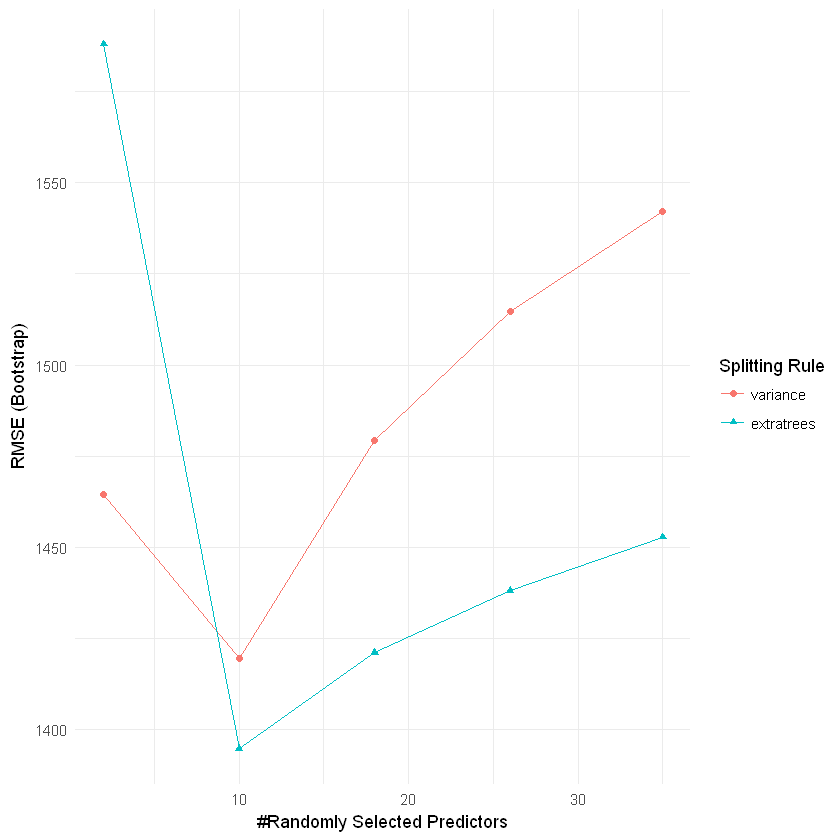

In [141]:
ggplot(mod_rf_tuned3)

In [142]:
# Create a new vector in the dataframe with model's predicted values 
test$rf_tuned3_preds <- predict(mod_rf_tuned3, test)

In [143]:
# Calculate out-of-sample R2
mod_rf_tuned3_OSR2 <- OSR2(test$rf_tuned3_preds, test$BioCNG3daysAhead, train$BioCNG3daysAhead)
mod_rf_tuned3_OSR2

[1] 0.8081028

#### XGBoost

In [144]:
#Train model
mod_xgb_tuned3 <-train(BioCNG3daysAhead ~ 
           cum_BioCNG_Output +
           BioCNG_Output +
           PigManure_Input + Cassava_Input + FishWaste_Input + FoodWaste_Input +
           MunFecalRes_Input + TeaWaste_Input + ChickLitter_Input + Baggasse_Input +
           AlcoWaste_Input + MedicineWaste_Input + EnergyGrass_Input + BananaShafts_Input +
           LemonWaste_Input + Percolate_Input + Other_Input + codigestedAmount + total_Input +
           cum_total_Input + cum_PigManure_Input + cum_Cassava_Input + cum_FishWaste_Input +
           cum_FoodWaste_Input + cum_MunFecalRes_Input + cum_TeaWaste_Input + 
           cum_ChickLitter_Input + cum_Baggasse_Input + cum_AlcoWaste_Input +
           cum_MedicineWaste_Input + cum_EnergyGrass_Input + cum_BananaShafts_Input +
           cum_LemonWaste_Input + cum_Percolate_Input + cum_Other_Input,
                     data=train,
                     method="xgbTree",
                     verbose=F,
                     metric="RMSE",
                     tuneLength = 3)

In [145]:
# Check model performance
mod_xgb_tuned3

eXtreme Gradient Boosting 

1222 samples
  35 predictor

No pre-processing
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 1222, 1222, 1222, 1222, 1222, 1222, ... 
Resampling results across tuning parameters:

  eta  max_depth  colsample_bytree  subsample  nrounds  RMSE      Rsquared 
  0.3  1          0.6               0.50        50      1609.027  0.7684626
  0.3  1          0.6               0.50       100      1610.701  0.7682182
  0.3  1          0.6               0.50       150      1616.665  0.7666101
  0.3  1          0.6               0.75        50      1595.007  0.7721027
  0.3  1          0.6               0.75       100      1604.921  0.7694897
  0.3  1          0.6               0.75       150      1607.534  0.7689934
  0.3  1          0.6               1.00        50      1580.213  0.7763399
  0.3  1          0.6               1.00       100      1580.999  0.7760173
  0.3  1          0.6               1.00       150      1582.180  0.7756466
  0.3  1         

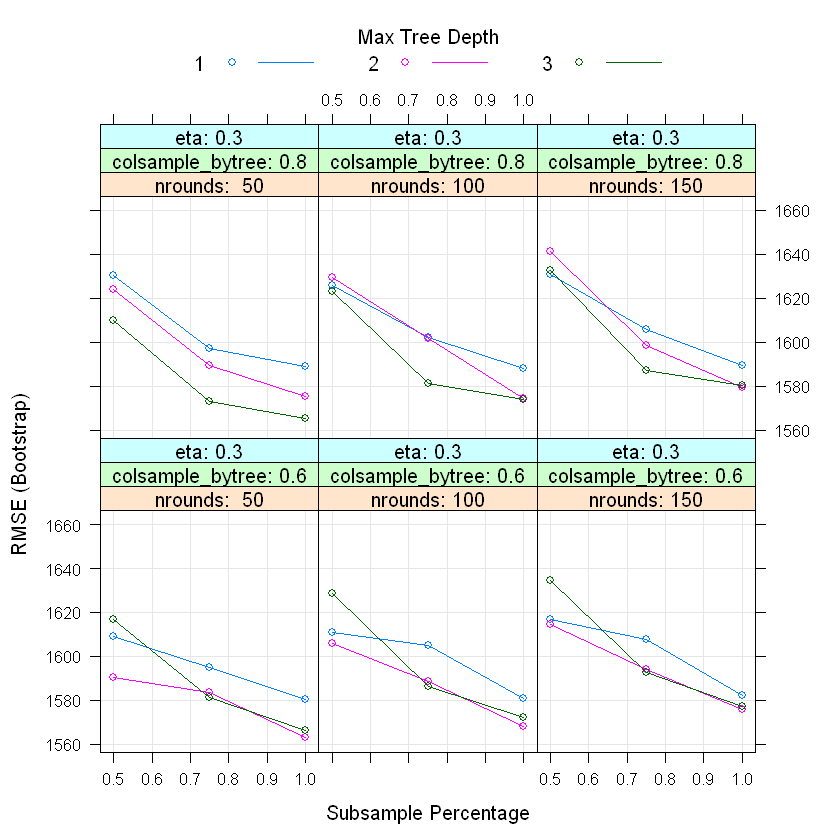

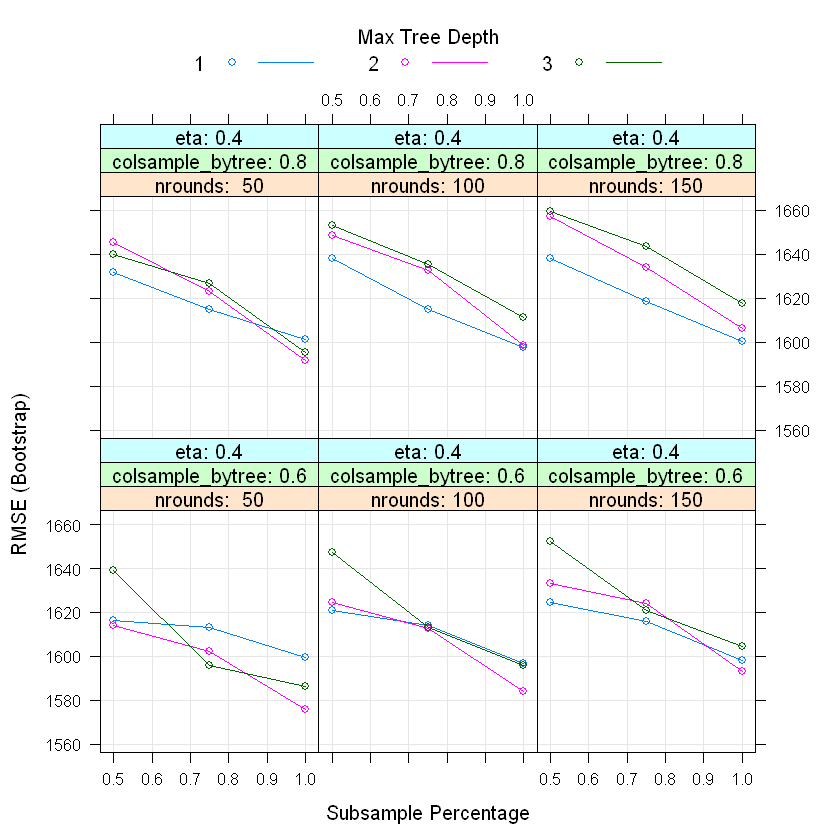

In [146]:
plot(mod_xgb_tuned3)

In [147]:
# Create a new vector in the dataframe with model's predicted values 
test$xgb_tuned3_preds <- predict(mod_xgb_tuned3, test)

In [148]:
# Calculate out-of-sample R2
mod_xgb_tuned3_OSR2 <- OSR2(test$xgb_tuned3_preds, test$BioCNG3daysAhead, train$BioCNG3daysAhead)
mod_xgb_tuned3_OSR2

[1] 0.8334784

### Testing optimal time frame: 1 day

#### Linear model

In [149]:
# Train model
mod_lm1 <- train(BioCNG1daysAhead ~ 
           cum_BioCNG_Output +
           BioCNG_Output +
           PigManure_Input + Cassava_Input + FishWaste_Input + FoodWaste_Input +
           MunFecalRes_Input + TeaWaste_Input + ChickLitter_Input + Baggasse_Input +
           AlcoWaste_Input + MedicineWaste_Input + EnergyGrass_Input + BananaShafts_Input +
           LemonWaste_Input + Percolate_Input + Other_Input + codigestedAmount + total_Input +
           cum_total_Input + cum_PigManure_Input + cum_Cassava_Input + cum_FishWaste_Input +
           cum_FoodWaste_Input + cum_MunFecalRes_Input + cum_TeaWaste_Input + 
           cum_ChickLitter_Input + cum_Baggasse_Input + cum_AlcoWaste_Input +
           cum_MedicineWaste_Input + cum_EnergyGrass_Input + cum_BananaShafts_Input +
           cum_LemonWaste_Input + cum_Percolate_Input + cum_Other_Input,
           method = "lm", metric = "RMSE",
           data = train)

Warning message in predict.lm(modelFit, newdata):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(modelFit, newdata):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(modelFit, newdata):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(modelFit, newdata):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(modelFit, newdata):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(modelFit, newdata):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(modelFit, newdata):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(modelFit, newdata):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(modelFit, newdata):
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(modelFit, newdat

In [150]:
# Check model performance
mod_lm1

Linear Regression 

1222 samples
  35 predictor

No pre-processing
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 1222, 1222, 1222, 1222, 1222, 1222, ... 
Resampling results:

  RMSE      Rsquared   MAE     
  1319.853  0.8419729  844.1675

Tuning parameter 'intercept' was held constant at a value of TRUE

In [151]:
# Create a new vector in the dataframe with model's predicted values 
test$lm1_preds <- predict(mod_lm1, test)

Warning message in predict.lm(modelFit, newdata):
"prediction from a rank-deficient fit may be misleading"

In [152]:
# Calculate out-of-sample R2
lm1_OSR2 <- OSR2(test$lm1_preds, test$BioCNG1daysAhead, train$BioCNG1daysAhead)
lm1_OSR2

[1] -2.158769

#### Elastic net

In [153]:
#Train model
mod_enet_tuned1 <-train(BioCNG1daysAhead ~ 
           cum_BioCNG_Output +
           BioCNG_Output +
           PigManure_Input + Cassava_Input + FishWaste_Input + FoodWaste_Input +
           MunFecalRes_Input + TeaWaste_Input + ChickLitter_Input + Baggasse_Input +
           AlcoWaste_Input + MedicineWaste_Input + EnergyGrass_Input + BananaShafts_Input +
           LemonWaste_Input + Percolate_Input + Other_Input + codigestedAmount + total_Input +
           cum_total_Input + cum_PigManure_Input + cum_Cassava_Input + cum_FishWaste_Input +
           cum_FoodWaste_Input + cum_MunFecalRes_Input + cum_TeaWaste_Input + 
           cum_ChickLitter_Input + cum_Baggasse_Input + cum_AlcoWaste_Input +
           cum_MedicineWaste_Input + cum_EnergyGrass_Input + cum_BananaShafts_Input +
           cum_LemonWaste_Input + cum_Percolate_Input + cum_Other_Input,
                     data=train,
                     method="glmnet",
                     metric="RMSE",
                     tuneLength = 5)

In [154]:
# Check model performance
mod_enet_tuned1

glmnet 

1222 samples
  35 predictor

No pre-processing
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 1222, 1222, 1222, 1222, 1222, 1222, ... 
Resampling results across tuning parameters:

  alpha  lambda       RMSE      Rsquared   MAE      
  0.100     2.778995  1346.209  0.8349995   854.4641
  0.100    12.898954  1346.190  0.8348801   854.5511
  0.100    59.871641  1348.743  0.8339582   864.5531
  0.100   277.899542  1348.548  0.8341292   894.3223
  0.100  1289.895409  1418.081  0.8273193  1002.7690
  0.325     2.778995  1346.602  0.8349020   853.9149
  0.325    12.898954  1347.757  0.8344189   855.9157
  0.325    59.871641  1352.542  0.8329131   874.2558
  0.325   277.899542  1349.027  0.8352328   898.7740
  0.325  1289.895409  1542.472  0.8203253  1133.8184
  0.550     2.778995  1346.721  0.8348619   853.8898
  0.550    12.898954  1349.436  0.8339399   858.1224
  0.550    59.871641  1348.400  0.8338919   873.3285
  0.550   277.899542  1373.012  0.8307651   918.0784
 

Warning message:
"Ignoring unknown aesthetics: shape"

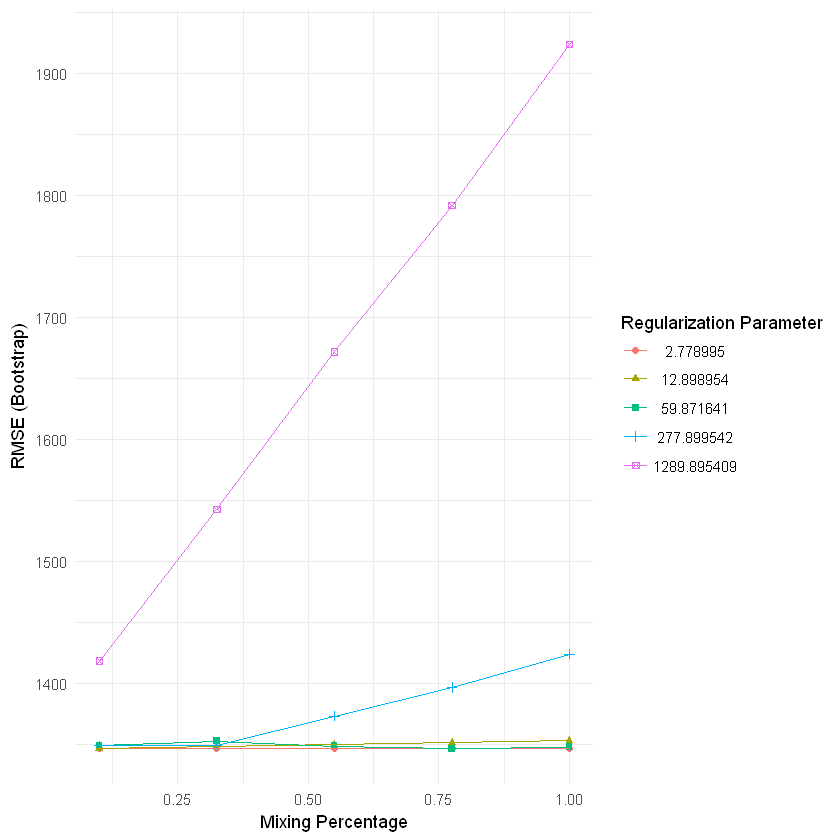

In [155]:
ggplot(mod_enet_tuned1)

In [156]:
# Create a new vector in the dataframe with model's predicted values 
test$enet1_preds <- predict(mod_enet_tuned1, test)

In [157]:
# Calculate out-of-sample R2
enet1_OSR2 <- OSR2(test$enet1_preds, test$BioCNG1daysAhead, train$BioCNG1daysAhead)
enet1_OSR2

[1] 0.9060551

#### Random forest

In [225]:
# Train model
mod_rf_tuned1 <- train(BioCNG1daysAhead ~ 
           cum_BioCNG_Output +
           BioCNG_Output +
           PigManure_Input + Cassava_Input + FishWaste_Input + FoodWaste_Input +
           MunFecalRes_Input + TeaWaste_Input + ChickLitter_Input + Baggasse_Input +
           AlcoWaste_Input + MedicineWaste_Input + EnergyGrass_Input + BananaShafts_Input +
           LemonWaste_Input + Percolate_Input + Other_Input + codigestedAmount + total_Input +
           cum_total_Input + cum_PigManure_Input + cum_Cassava_Input + cum_FishWaste_Input +
           cum_FoodWaste_Input + cum_MunFecalRes_Input + cum_TeaWaste_Input + 
           cum_ChickLitter_Input + cum_Baggasse_Input + cum_AlcoWaste_Input +
           cum_MedicineWaste_Input + cum_EnergyGrass_Input + cum_BananaShafts_Input +
           cum_LemonWaste_Input + cum_Percolate_Input + cum_Other_Input,
           method = "ranger", metric = "RMSE", tuneLength = 5, importance = "impurity",
           data = train)

In [226]:
# Check model performance
mod_rf_tuned1

Random Forest 

1222 samples
  35 predictor

No pre-processing
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 1222, 1222, 1222, 1222, 1222, 1222, ... 
Resampling results across tuning parameters:

  mtry  splitrule   RMSE      Rsquared   MAE      
   2    variance    1369.038  0.8372255   925.4534
   2    extratrees  1485.635  0.8127084  1042.1508
  10    variance    1318.756  0.8430167   822.2571
  10    extratrees  1283.027  0.8515781   805.6729
  18    variance    1347.948  0.8360709   843.4833
  18    extratrees  1301.664  0.8470640   816.2668
  26    variance    1374.167  0.8297359   860.4260
  26    extratrees  1315.038  0.8438597   823.3219
  35    variance    1404.745  0.8221689   879.4227
  35    extratrees  1325.913  0.8412405   830.4470

Tuning parameter 'min.node.size' was held constant at a value of 5
RMSE was used to select the optimal model using the smallest value.
The final values used for the model were mtry = 10, splitrule = extratrees
 and min.node.siz

Warning message:
"Ignoring unknown aesthetics: shape"

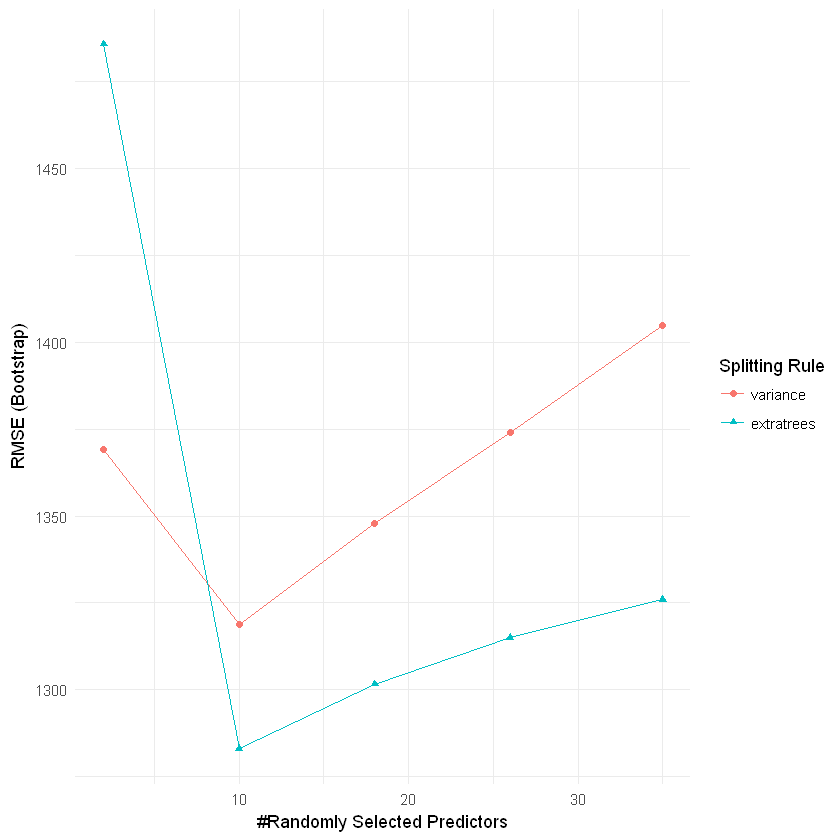

In [227]:
ggplot(mod_rf_tuned1)

In [228]:
# Create a new vector in the dataframe with model's predicted values 
test$rf_tuned1_preds <- predict(mod_rf_tuned1, test)

In [265]:
# Calculate out-of-sample R2
mod_rf_tuned1_OSR2 <- OSR2(test$rf_tuned1_preds, test$BioCNG1daysAhead, train$BioCNG1daysAhead)
mod_rf_tuned1_OSR2

[1] 0.8808792

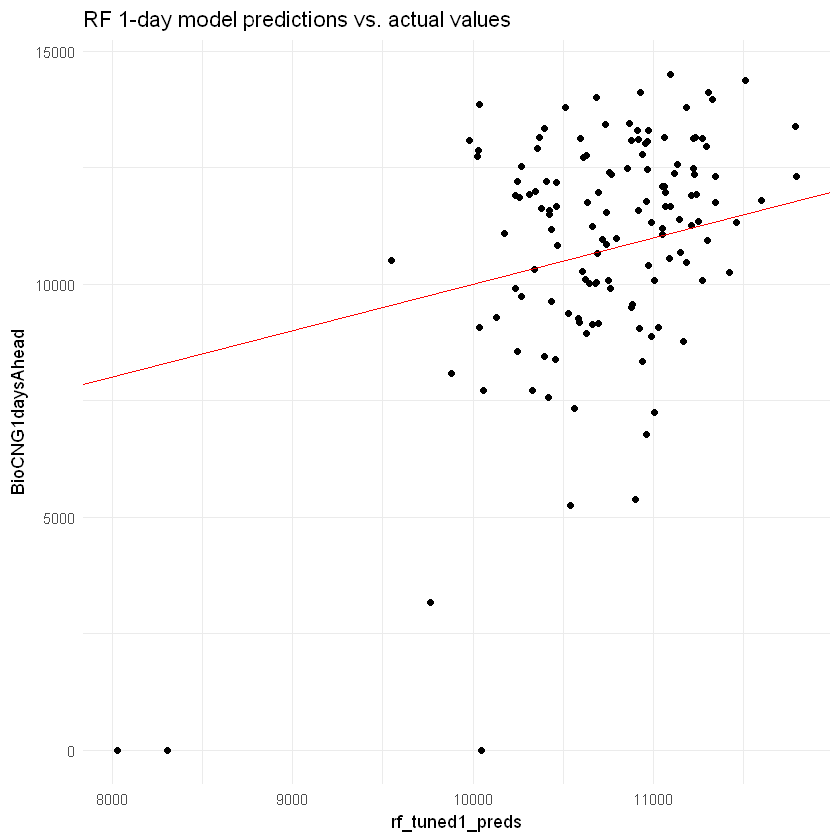

In [266]:
# Scatterplot of predicted vs. acual values
ggplot(test, aes(x=rf_tuned1_preds, y=BioCNG1daysAhead)) + 
  geom_point() +
  geom_abline(color = 'red') +
  ggtitle("RF 1-day model predictions vs. actual values")

In [267]:
# New vector of residuals
test$rf_tuned1_residuals <- test$BioCNG1daysAhead - test$rf_tuned1_preds

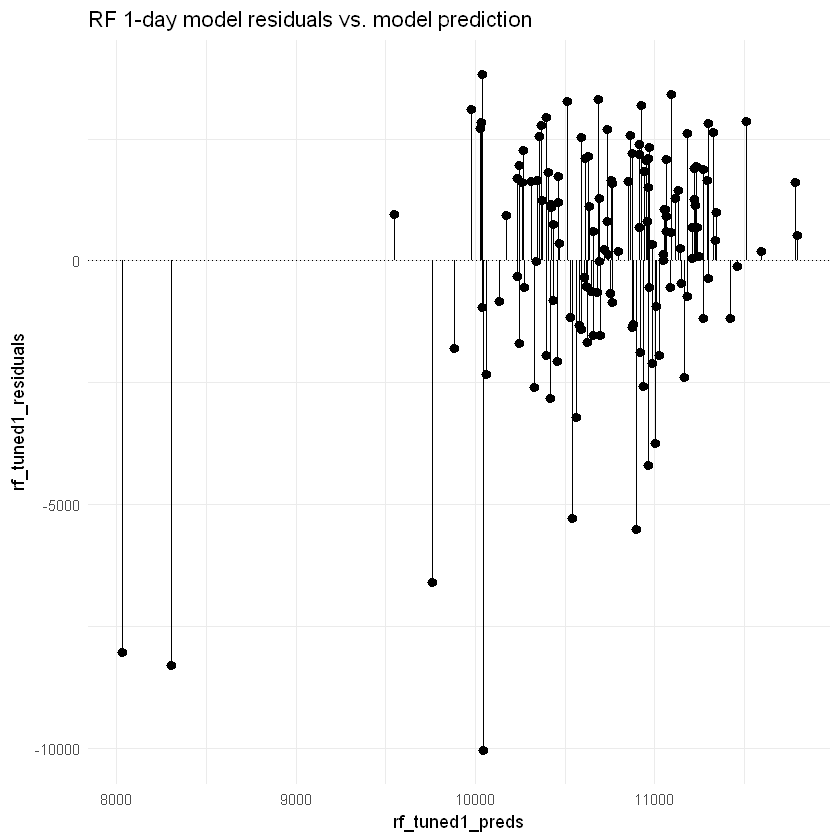

In [268]:
# plot of residuals 
ggplot(test, aes(x = rf_tuned1_preds, y = rf_tuned1_residuals)) + 
  geom_pointrange(aes(ymin = 0, ymax = rf_tuned1_residuals)) + 
  geom_hline(yintercept = 0, linetype = 3) + 
  ggtitle("RF 1-day model residuals vs. model prediction")

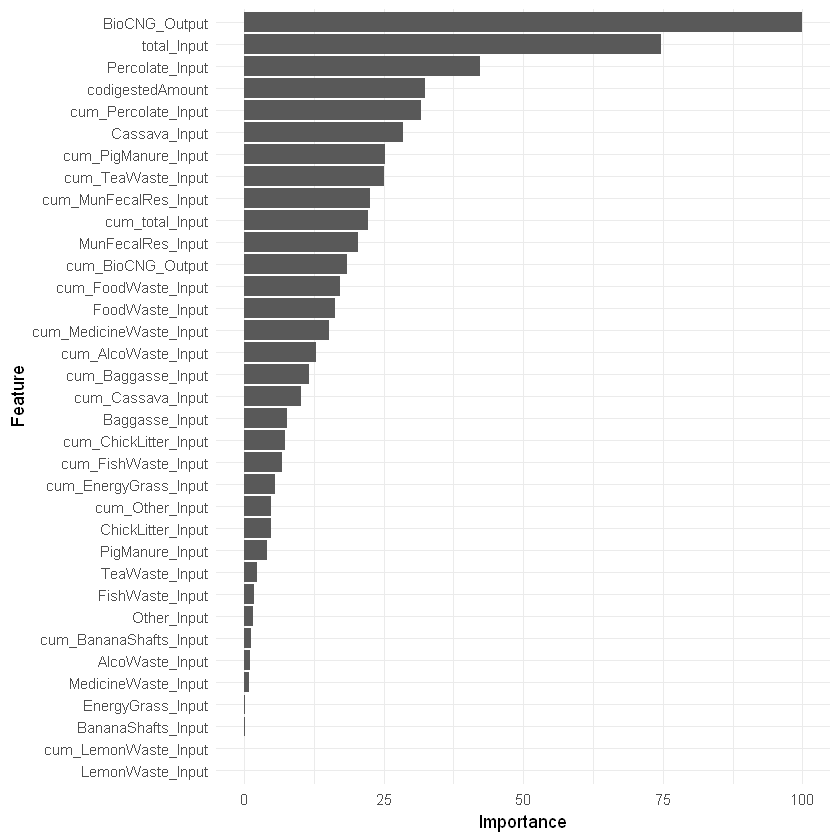

In [269]:
# Variable importance plot
ggplot(varImp(mod_rf_tuned1))

#### XGBoost

In [242]:
#Train model
mod_xgb_tuned1 <-train(BioCNG1daysAhead ~ 
           cum_BioCNG_Output +
           BioCNG_Output +
           PigManure_Input + Cassava_Input + FishWaste_Input + FoodWaste_Input +
           MunFecalRes_Input + TeaWaste_Input + ChickLitter_Input + Baggasse_Input +
           AlcoWaste_Input + MedicineWaste_Input + EnergyGrass_Input + BananaShafts_Input +
           LemonWaste_Input + Percolate_Input + Other_Input + codigestedAmount + total_Input +
           cum_total_Input + cum_PigManure_Input + cum_Cassava_Input + cum_FishWaste_Input +
           cum_FoodWaste_Input + cum_MunFecalRes_Input + cum_TeaWaste_Input + 
           cum_ChickLitter_Input + cum_Baggasse_Input + cum_AlcoWaste_Input +
           cum_MedicineWaste_Input + cum_EnergyGrass_Input + cum_BananaShafts_Input +
           cum_LemonWaste_Input + cum_Percolate_Input + cum_Other_Input,
                     data=train,
                     method="xgbTree",
                     verbose=F,
                     metric="RMSE", importance = "impurity",
                     tuneLength = 3)

In [243]:
# Check model performance
mod_xgb_tuned1

eXtreme Gradient Boosting 

1222 samples
  35 predictor

No pre-processing
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 1222, 1222, 1222, 1222, 1222, 1222, ... 
Resampling results across tuning parameters:

  eta  max_depth  colsample_bytree  subsample  nrounds  RMSE      Rsquared 
  0.3  1          0.6               0.50        50      1380.230  0.8281892
  0.3  1          0.6               0.50       100      1386.330  0.8275035
  0.3  1          0.6               0.50       150      1396.291  0.8252921
  0.3  1          0.6               0.75        50      1371.937  0.8303680
  0.3  1          0.6               0.75       100      1379.820  0.8290869
  0.3  1          0.6               0.75       150      1388.644  0.8270874
  0.3  1          0.6               1.00        50      1368.357  0.8309951
  0.3  1          0.6               1.00       100      1375.109  0.8296700
  0.3  1          0.6               1.00       150      1380.996  0.8284515
  0.3  1         

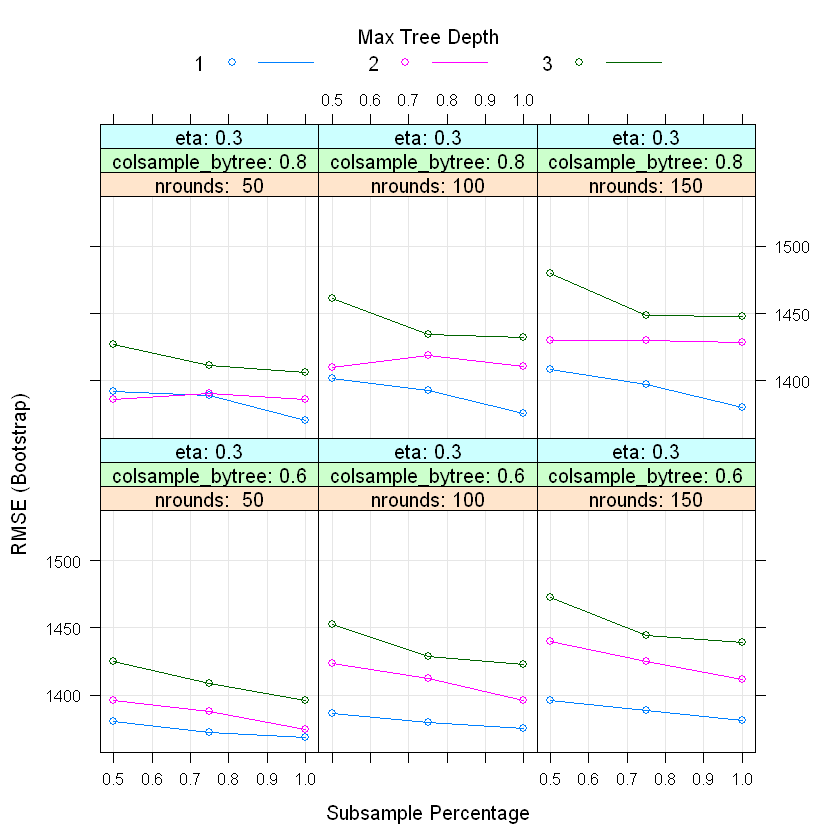

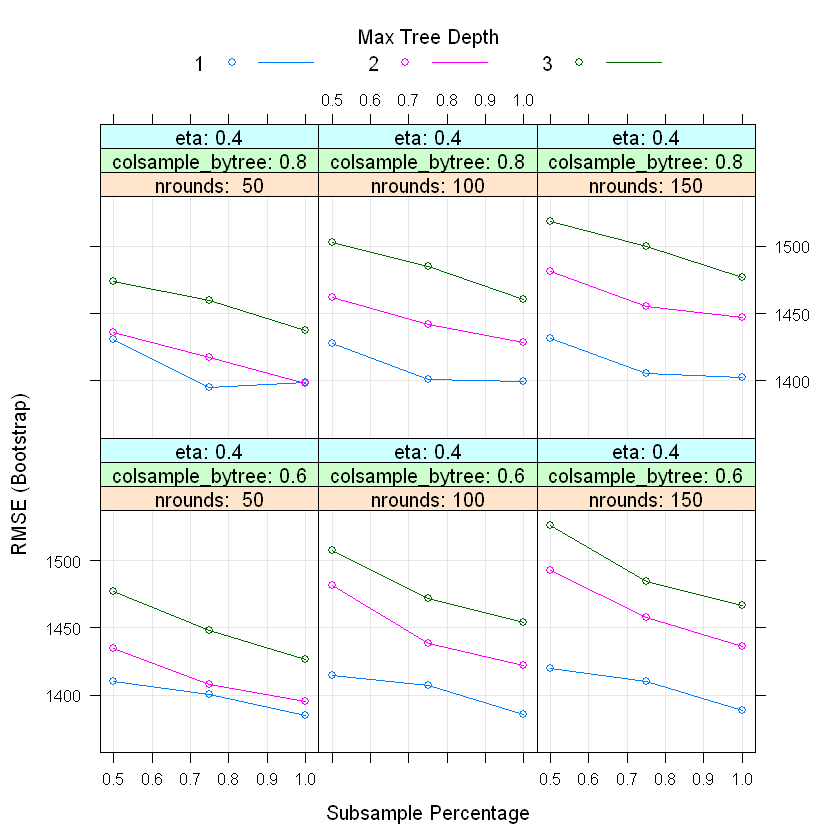

In [244]:
plot(mod_xgb_tuned1)

In [245]:
# Create a new vector in the dataframe with model's predicted values 
test$xgb_tuned1_preds <- predict(mod_xgb_tuned1, test)

In [246]:
# Calculate out-of-sample R2
mod_xgb_tuned1_OSR2 <- OSR2(test$xgb_tuned1_preds, test$BioCNG1daysAhead, train$BioCNG1daysAhead)
mod_xgb_tuned1_OSR2

[1] 0.9042902

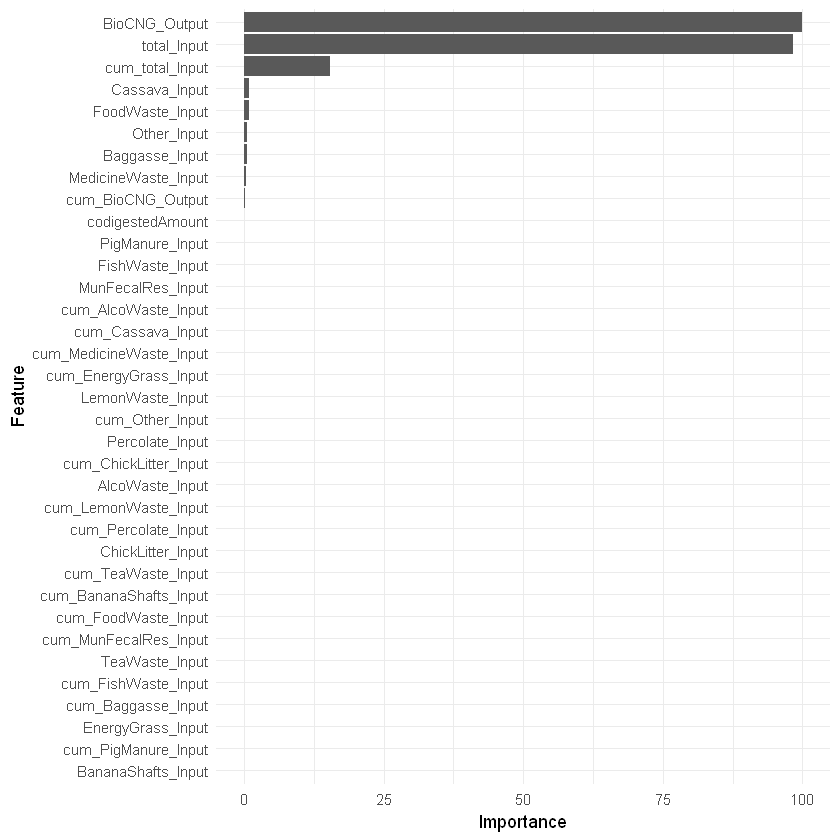

In [247]:
# Variable importance plot
ggplot(varImp(mod_xgb_tuned1))

### Model comparison

In [168]:
TimeLead <- c('1 day', '3 days', '5 days', '10 days', '20 days', '30 days', '40 days')
LinearMod <- c(lm1_OSR2, lm3_OSR2, lm5_OSR2, lm10_OSR2, lm20_OSR2, lm30_OSR2, lm40_OSR2)
ElasticNet <- c(enet1_OSR2, enet3_OSR2, enet5_OSR2, enet10_OSR2, enet20_OSR2, enet30_OSR2, enet40_OSR2)
RandomForest <- c(mod_rf_tuned1_OSR2, mod_rf_tuned3_OSR2, mod_rf_tuned5_OSR2, mod_rf_tuned10_OSR2, mod_rf_tuned20_OSR2, mod_rf_tuned30_OSR2, mod_rf_tuned40_OSR2)
XGBoost <- c(mod_xgb_tuned1_OSR2, mod_xgb_tuned3_OSR2, mod_xgb_tuned5_OSR2, mod_xgb_tuned10_OSR2, mod_xgb_tuned20_OSR2, mod_xgb_tuned30_OSR2, mod_xgb_tuned40_OSR2)

In [169]:
performance <- data.frame(TimeLead, LinearMod, ElasticNet, RandomForest, XGBoost)

In [223]:
performance

TimeLead,LinearMod,ElasticNet,RandomForest,XGBoost
1 day,-2.1587687,0.90605514,0.8784046,0.9078603
3 days,-2.7435298,0.45626348,0.8081028,0.8334784
5 days,-0.5347185,0.57634551,0.8489727,0.8588548
10 days,-0.9196106,-0.07571525,0.8518041,0.8354809
20 days,-4.4794333,-0.39469596,0.8497562,0.8490203
30 days,-1.5946127,0.66692104,0.8389080,0.8256904
40 days,-0.3614132,0.35049975,0.8155370,0.8087224


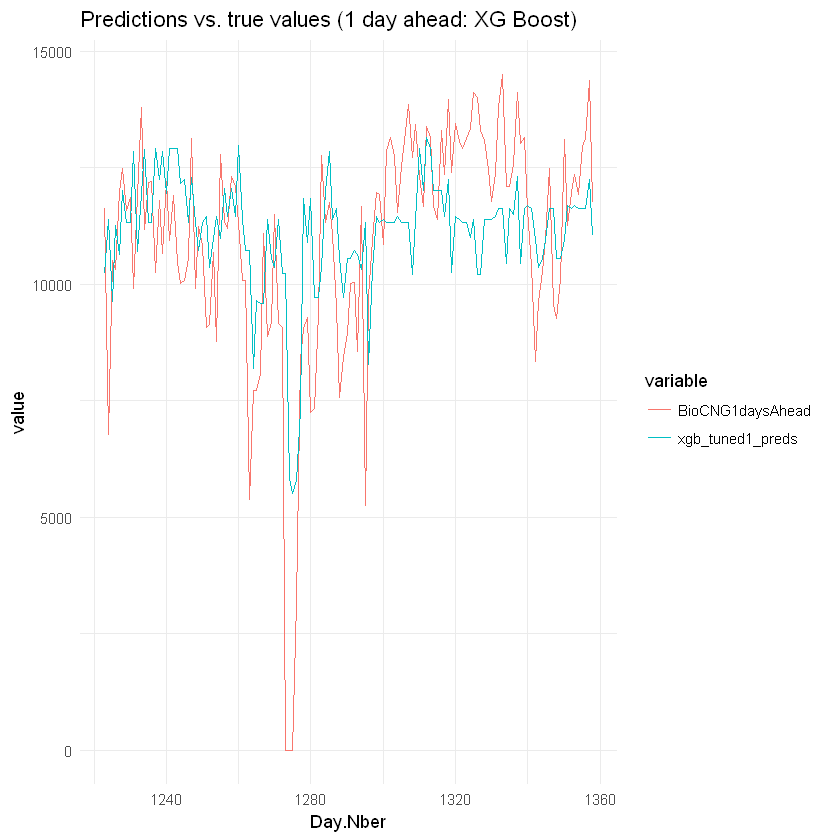

In [343]:
# Comparison of predictions vs. truth: 1 day XGB
rm(compare_1)
compare_1 <- select(test,Day.Nber)

compare_1$BioCNG1daysAhead <- test$BioCNG1daysAhead
compare_1$xgb_tuned1_preds <- test$xgb_tuned1_preds
compare_1 <- melt(compare_1, id = "Day.Nber")

ggplot(data=compare_1,
       aes(x=Day.Nber, y=value, colour=variable)) + ggtitle("Predictions vs. true values (1 day ahead: XG Boost)") +
       geom_line()

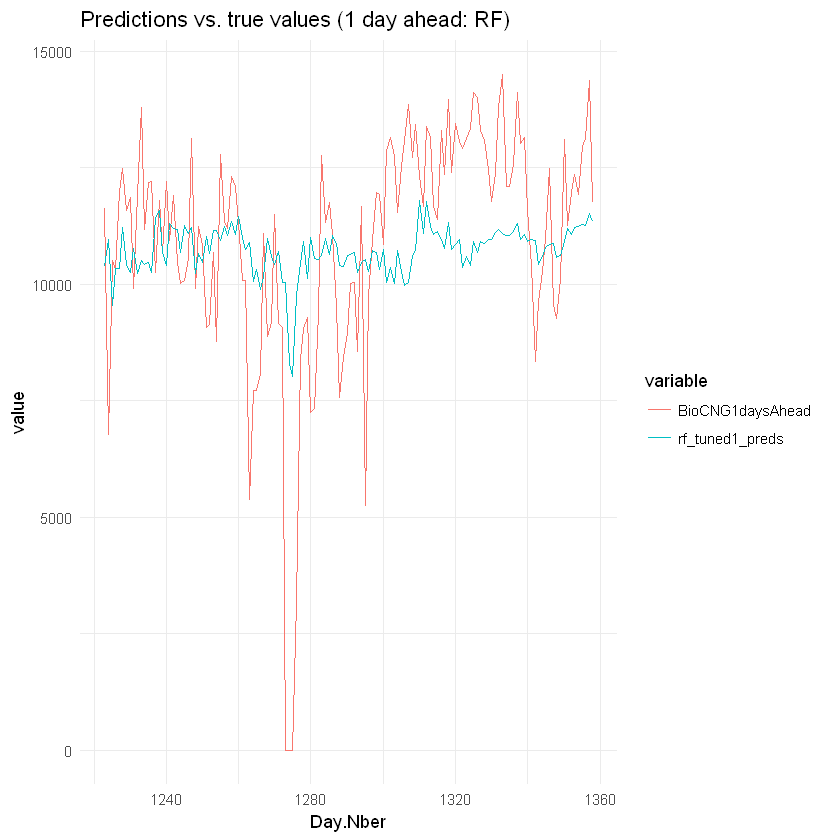

In [344]:
# Comparison of predictions vs. truth: 1 day RF
rm(compare_1)
compare_1 <- select(test,Day.Nber)

compare_1$BioCNG1daysAhead <- test$BioCNG1daysAhead
compare_1$rf_tuned1_preds <- test$rf_tuned1_preds
compare_1 <- melt(compare_1, id = "Day.Nber")

ggplot(data=compare_1,
       aes(x=Day.Nber, y=value, colour=variable)) + ggtitle("Predictions vs. true values (1 day ahead: RF)") +
       geom_line()

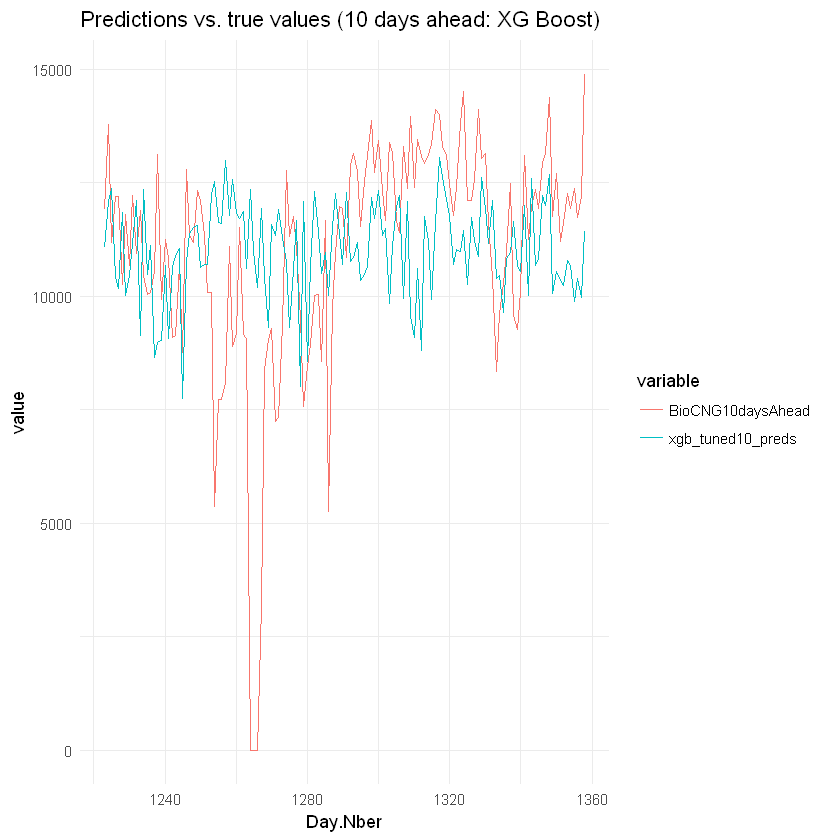

In [345]:
# Comparison of predictions vs. truth: 10 days XGB
rm(compare_10)
compare_10 <- select(test,Day.Nber)

compare_10$BioCNG10daysAhead <- test$BioCNG10daysAhead
compare_10$xgb_tuned10_preds <- test$xgb_tuned10_preds
compare_10 <- melt(compare_10, id = "Day.Nber")

ggplot(data=compare_10,
       aes(x=Day.Nber, y=value, colour=variable)) + ggtitle("Predictions vs. true values (10 days ahead: XG Boost)") +
       geom_line()

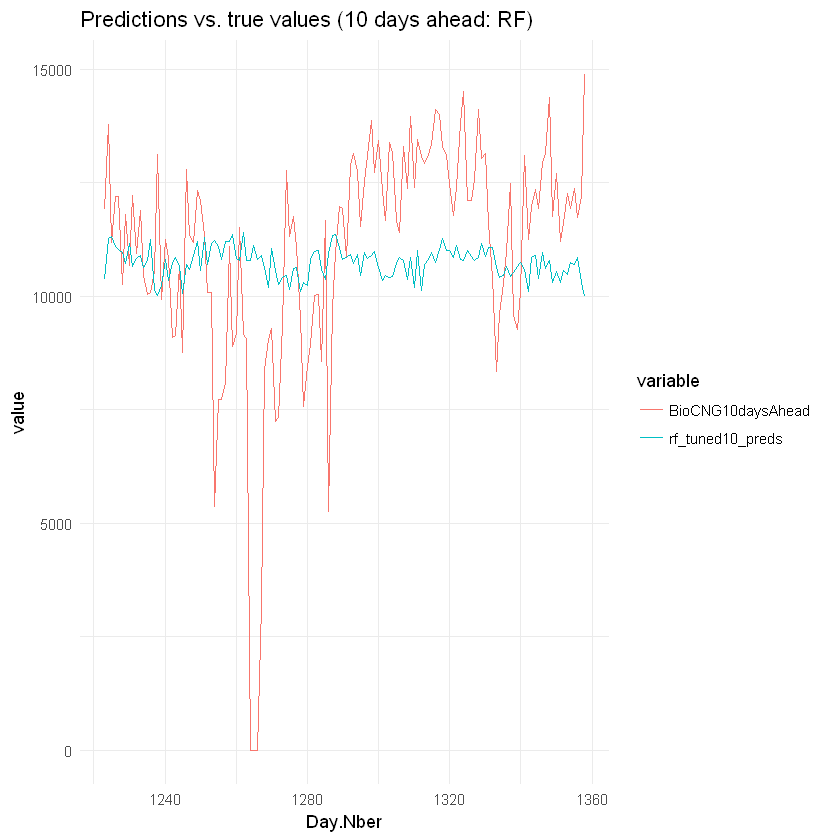

In [336]:
# Comparison of predictions vs. truth: 10 days RF
rm(compare_10)
compare_10 <- select(test,Day.Nber)

compare_10$BioCNG10daysAhead <- test$BioCNG10daysAhead
compare_10$rf_tuned10_preds <- test$rf_tuned10_preds
compare_10 <- melt(compare_10, id = "Day.Nber")

ggplot(data=compare_10,
       aes(x=Day.Nber, y=value, colour=variable)) + ggtitle("Predictions vs. true values (10 days ahead: RF)") +
       geom_line()

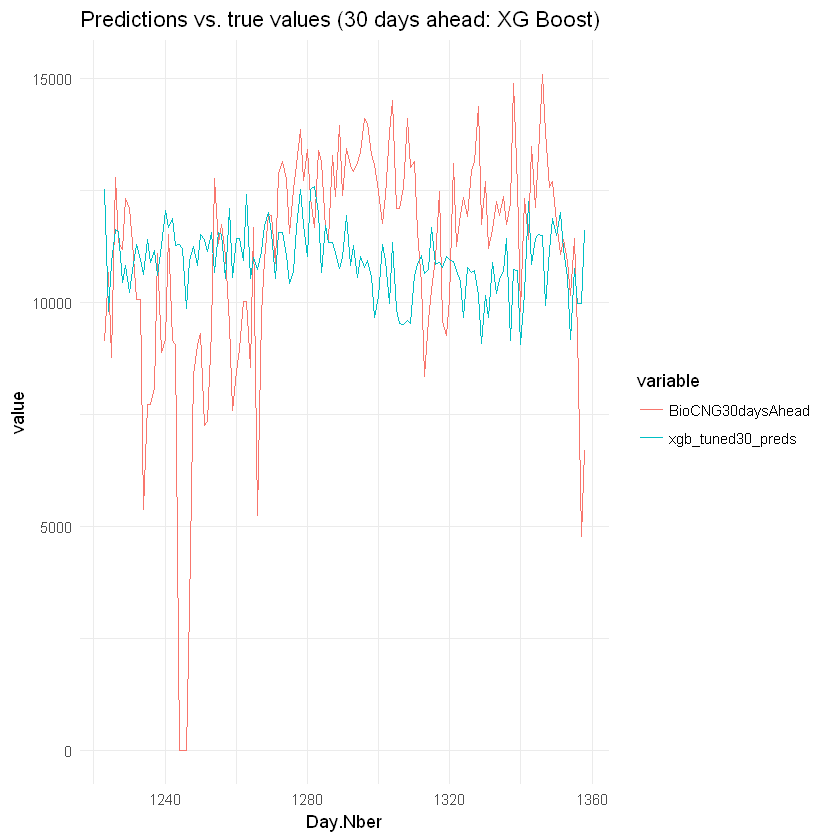

In [338]:
# Comparison of predictions vs. truth: 30 days XGB
rm(compare_30)
compare_30 <- select(test,Day.Nber)

compare_30$BioCNG30daysAhead <- test$BioCNG30daysAhead
compare_30$xgb_tuned30_preds <- test$xgb_tuned30_preds
compare_30 <- melt(compare_30, id = "Day.Nber")

ggplot(data=compare_30,
       aes(x=Day.Nber, y=value, colour=variable)) + ggtitle("Predictions vs. true values (30 days ahead: XG Boost)") +
       geom_line()

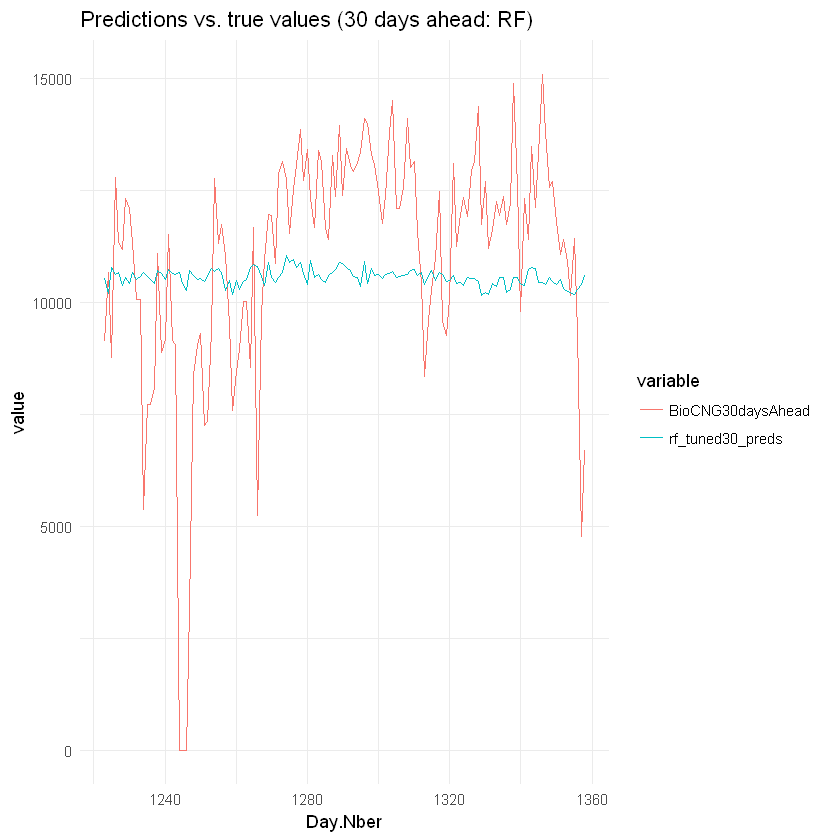

In [339]:
# Comparison of predictions vs. truth: 30 days RF
rm(compare_30)
compare_30 <- select(test,Day.Nber)

compare_30$BioCNG30daysAhead <- test$BioCNG30daysAhead
compare_30$rf_tuned30_preds <- test$rf_tuned30_preds
compare_30 <- melt(compare_30, id = "Day.Nber")

ggplot(data=compare_30,
       aes(x=Day.Nber, y=value, colour=variable)) + ggtitle("Predictions vs. true values (30 days ahead: RF)") +
       geom_line()

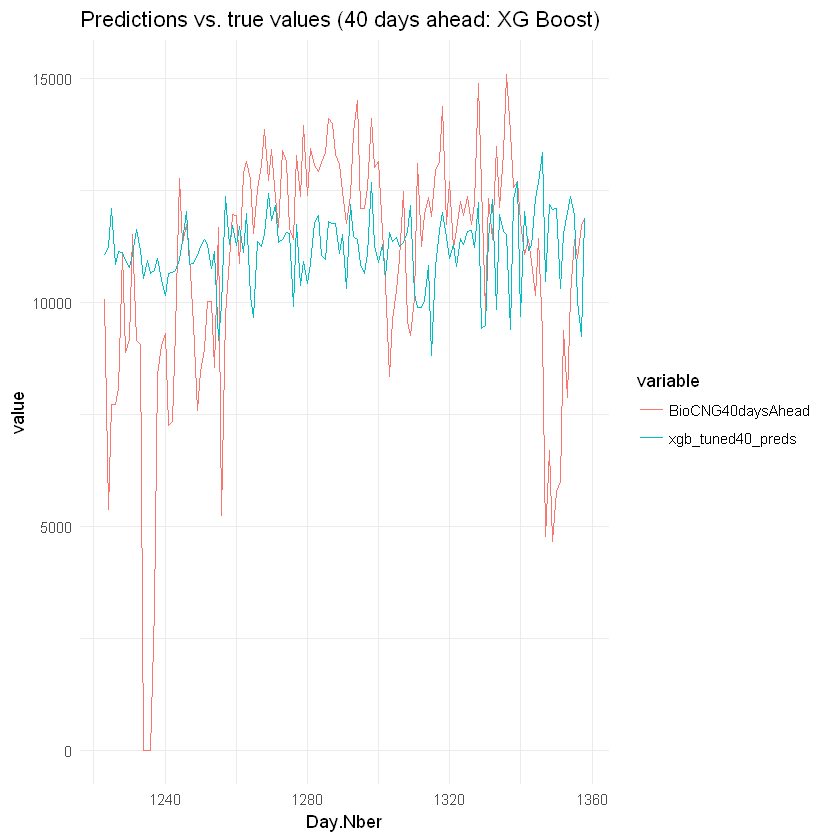

In [340]:
# Comparison of predictions vs. truth: 40 days XGB
rm(compare_40)
compare_40 <- select(test,Day.Nber)

compare_40$BioCNG40daysAhead <- test$BioCNG40daysAhead
compare_40$xgb_tuned40_preds <- test$xgb_tuned40_preds
compare_40 <- melt(compare_40, id = "Day.Nber")

ggplot(data=compare_40,
       aes(x=Day.Nber, y=value, colour=variable)) + ggtitle("Predictions vs. true values (40 days ahead: XG Boost)") +
       geom_line()

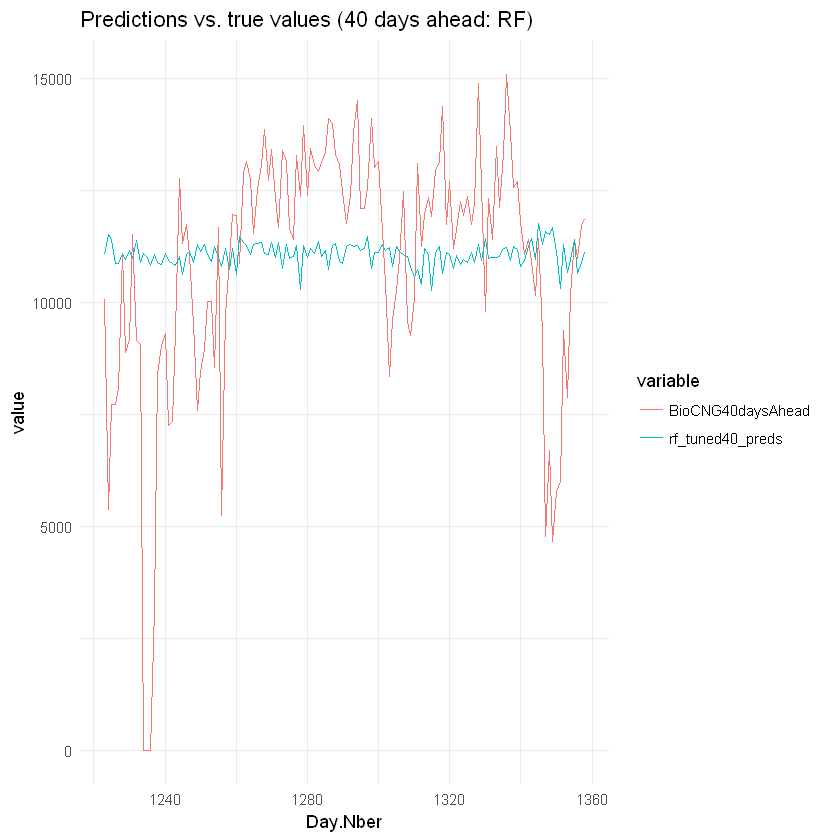

In [341]:
# Comparison of predictions vs. truth: 40 days RF
rm(compare_40)
compare_40 <- select(test,Day.Nber)

compare_40$BioCNG40daysAhead <- test$BioCNG40daysAhead
compare_40$rf_tuned40_preds <- test$rf_tuned40_preds
compare_40 <- melt(compare_40, id = "Day.Nber")

ggplot(data=compare_40,
       aes(x=Day.Nber, y=value, colour=variable)) + ggtitle("Predictions vs. true values (40 days ahead: RF)") +
       geom_line()